In [2]:
from vtl.Readfile import Readfile
from spec_id import Analyze_Stack_avgage, Error,Oldest_galaxy, Gen_spec, \
    Combine_1D_parameters, Stack,Median_model, Median_w_Error,Median_w_Error_cont,Likelihood_contours, \
    Gen_sim
from astropy.table import Table
from astropy.io import fits
import astropy.units as u
from astropy.cosmology import Planck13, z_at_value
from scipy.interpolate import interp1d
from scipy.ndimage import interpolation
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
from matplotlib.ticker import AutoMinorLocator
from mpl_toolkits.axes_grid.inset_locator import inset_axes
import rpy2
import rpy2.robjects as robjects
R = robjects.r
from glob import glob
import seaborn as sea
import numpy as np
import pandas as pd
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direction': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
colors = [(0,i,i,i) for i in np.linspace(0,1,3)]
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.2, as_cmap=True)

In [3]:
galDB = pd.read_pickle('../data/sgal_param_DB.pkl')
metal=np.arange(0.002,0.031,0.001)
age=np.arange(.5,6.1,.1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

In [4]:
galDB

,gids,ids,ra,dec,hi_res_specz,lmass,tau,Z_f,Z_-_sig_f,Z_+_sig_f,...,tx_+_sig_lwa,Zx_lwa,Zx_-_sig_lwa,Zx_+_sig_lwa,Z_lwa,Z_-_sig_lwa,Z_+_sig_lwa,t_lwa,t_-_sig_lwa,t_+_sig_lwa
43,n14713,14713,189.236333,62.214608,1.232,10.56,8.78,0.018,0.011,0.008,...,0.584168,0.015860,0.010100,0.009483,0.016,0.010,0.009,2.2,0.686,0.504
49,n16758,16758,189.162357,62.224840,1.014,10.83,0.00,0.020,0.001,0.002,...,0.242485,0.020068,0.001347,0.002918,0.021,0.002,0.002,4.9,0.509,0.207
50,n17070,17070,189.268086,62.226445,1.192,10.92,8.48,0.011,0.003,0.004,...,0.617234,0.010305,0.002581,0.004489,0.011,0.003,0.004,2.0,0.508,0.583
58,n19442,19442,189.123036,62.237460,1.101,10.10,8.90,0.015,0.009,0.010,...,1.069138,0.013952,0.008305,0.010605,0.014,0.008,0.011,2.4,0.875,1.010
61,n21156,21156,189.239409,62.247548,1.251,11.16,8.30,0.020,0.005,0.004,...,0.440882,0.019956,0.004545,0.004208,0.020,0.005,0.004,1.7,0.351,0.442
62,n21427,21427,189.368121,62.247344,1.514,10.73,8.48,0.019,0.010,0.007,...,0.617234,0.017880,0.008697,0.008248,0.018,0.009,0.008,2.0,0.662,0.539
69,n23435,23435,189.338306,62.256571,1.134,10.27,8.60,0.014,0.006,0.009,...,0.892786,0.014120,0.006228,0.008978,0.015,0.007,0.008,3.0,0.781,0.884
86,n32566,32566,189.161280,62.307577,1.150,10.61,8.70,0.020,0.008,0.006,...,0.672345,0.019339,0.007631,0.007014,0.020,0.008,0.006,1.6,0.604,0.653
96,n34694,34694,189.147840,62.323647,1.145,10.94,8.30,0.015,0.006,0.005,...,0.991984,0.014345,0.004882,0.005667,0.015,0.006,0.005,2.4,0.478,0.988
107,n37686,37686,189.274474,62.360820,1.258,10.89,8.48,0.016,0.003,0.004,...,0.584168,0.015411,0.002413,0.004321,0.016,0.003,0.004,3.0,0.505,0.531


#UVJ plot

In [79]:
###DATA 
uvjDB = pd.read_pickle('../data/uvj_db.pkl')
uvjSDB = uvjDB[uvjDB['IN_SAMP'] == True]
uvjSDB = uvjSDB.query('ra != 189.236333 and ra != 189.284502')

In [80]:
###PLOTS
%matplotlib inline

# plt.figure(figsize=[10,10])
# plt.plot(uvjDB['(V-J)'],uvjDB['(U-V)'],'o',color='#127794', alpha=.5,ms=3, label = 'Star Forming')
# plt.plot(uvjDB['(V-J)'][uvjDB['Q/S'] == 'q'],uvjDB['(U-V)'][uvjDB['Q/S'] == 'q'],'o',color='#E81524', alpha=.5,ms=3, label = 'Quiscent')
# plt.plot(uvjDB['(V-J)'][uvjDB['IN_SAMP'] == True],uvjDB['(U-V)'][uvjDB['IN_SAMP'] == True],'d',color='#93000B',ms=10, label = 'Selected Sample')
# plt.plot([0,.9],[1.382,1.382],'k',lw=.9)
# plt.plot([1.65,1.65],[2.045,2.5],'k',lw=.9)
# plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=.9)
# plt.axis([0,2.5,.5,2.5])
# plt.legend(loc=2,fontsize=23)
# plt.xlabel('(V-J)',fontsize=30)
# plt.ylabel('(U-V)',fontsize=30)
# plt.tick_params(axis='both', which='major', labelsize=23)
# plt.minorticks_on()
# plt.gcf().subplots_adjust(bottom=0.16)
# # plt.show()
# plt.savefig('../plots/uvj_plot_6-28.png')
# plt.close()

plt.figure(figsize=[10,10])
sea.kdeplot(uvjDB['(V-J)'],uvjDB['(U-V)'],n_levels = 7,alpha = .8,shade=True,cmap=cmap,kernel= 'epa',zorder=1)
plt.plot(uvjSDB['(V-J)'],uvjSDB['(U-V)'],'o',color='#93000B',ms=8, label = 'Selected Sample')
plt.plot([0,.9],[1.382,1.382],'k',lw=.9,linewidth=3)
plt.plot([1.65,1.65],[2.045,2.5],'k',lw=.9,linewidth=3)
plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=.9,linewidth=3)
plt.axis([0,2.5,.5,2.5])
plt.legend(fontsize=23)
plt.xlabel('(V-J) mag',fontsize=30)
plt.ylabel('(U-V) mag',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=23,length = 7, width=2)
plt.minorticks_on()
plt.gcf().subplots_adjust(bottom=0.16)
# plt.show()
plt.savefig('../plots/uvj_kde_plot_8-27.pdf',bbox_inches = 'tight')
plt.close()

/Users/vestrada/miniconda2/envs/astroconda/lib/python2.7/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs [u'lw', u'linewidth'] which are all aliases for u'linewidth'.  Kept value from u'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))


#Example Spectra and Best Fit

In [ ]:
###DATA
spec = Gen_spec(galDB['gids'][61], galDB['hi_res_specz'][61],delayed=True,maxwv=11400)
bftau = Median_model(galDB['gids'][61], galDB['hi_res_specz'][61], galDB['Z_lwa'][61], galDB['t_lwa'][61], tau)
spec.Sim_spec(galDB['Z_lwa'][61],galDB['t_lwa'][61],bftau)


In [19]:
###PLOT
%matplotlib inline

sea.set_style( {"xtick.major.size": 8, "ytick.major.size": 8,
                "xtick.minor.size": 5, "ytick.minor.size": 5})
plt.figure(figsize=(15,6))
plt.errorbar(spec.gal_wv_rf,spec.gal_fl*1E18,spec.gal_er*1E18,fmt='o',color='#0571b0', alpha = .8,ms=5,label = 'Galaxy Spectra')
plt.plot(spec.gal_wv_rf,spec.fl*1E18, color='#ca0020',
         label='Median fit\nZ/Z$_\odot$=%s,\nt=%s Gyrs' % (np.round(galDB['Z_lwa'][61]/0.019,2),galDB['t_lwa'][61]))
plt.axvline(3934.777,linestyle='--', alpha=.3)
plt.axvline(3969.588,linestyle='--', alpha=.3)
plt.axvline(4102.89,linestyle='--', alpha=.3)
plt.axvline(4305.61,linestyle='--', alpha=.3)
plt.axvline(4341.68,linestyle='--', alpha=.3)
plt.axvline(4862.68,linestyle='--', alpha=.3)
plt.axvline(5176.7,linestyle='--', alpha=.3)
plt.axvspan(3910, 3980, color='k', alpha=.1)
plt.axvspan(3980, 4030, color='k', alpha=.1)
plt.axvspan(4080, 4120, color='k', alpha=.1)
plt.axvspan(4250, 4380, color='k', alpha=.1)
plt.axvspan(4810, 4910, color='k', alpha=.1)
plt.axvspan(5120, 5240, color='k', alpha=.1)
plt.text(3850,3.6,'Ca HK',fontsize=20)
plt.text(4080,3.6,'H$\delta$',fontsize=20)
plt.text(4250,3.6,'G+H$\gamma$',fontsize=20)
plt.text(4830,3.6,'H$\\beta$',fontsize=20)
# plt.text(5160,5.6,'Mgb',fontsize=25)
plt.xlim(3500,5100)
plt.ylim(0,3.5)
plt.ylabel('F$_\lambda$ (10$^{-18}$ erg/s/cm$^2$/$\AA$)',size=30)
plt.xlabel('Restframe Wavelength ($\AA$)',size=30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.gcf().subplots_adjust(bottom=0.235)
plt.legend(loc=4,fontsize=20)
plt.minorticks_on()
# plt.show()
plt.savefig('../plots/n21156_spec_10-17.pdf',bbox_inches = 'tight')
plt.close()

#Grizli Example

In [3]:
###DATA
spec = Gen_spec(galDB['gids'][220], galDB['hi_res_specz'][220],maxwv=11400)
spec.Sim_spec(galDB['Z_f'][220],galDB['t_f'][220],8.48)
wv,fl = np.load('../../../fsps_models_for_fit/fsps_spec/m0.023_a3.4_t8.48_spec.npy')

The following tasks in the stwcs.gui package can be run with TEAL:
     apply_headerlet          archive_headerlet          attach_headerlet     
     delete_headerlet         extract_headerlet         headerlet_summary     
    restore_headerlet             updatewcs              write_headerlet




../data/galaxy_flts/s39170_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39170_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39170_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39170_flt: save ../data/galaxy_flts/s39170_flt.detect_seg.fits, ../data/galaxy_flts/s39170_flt.detect.cat


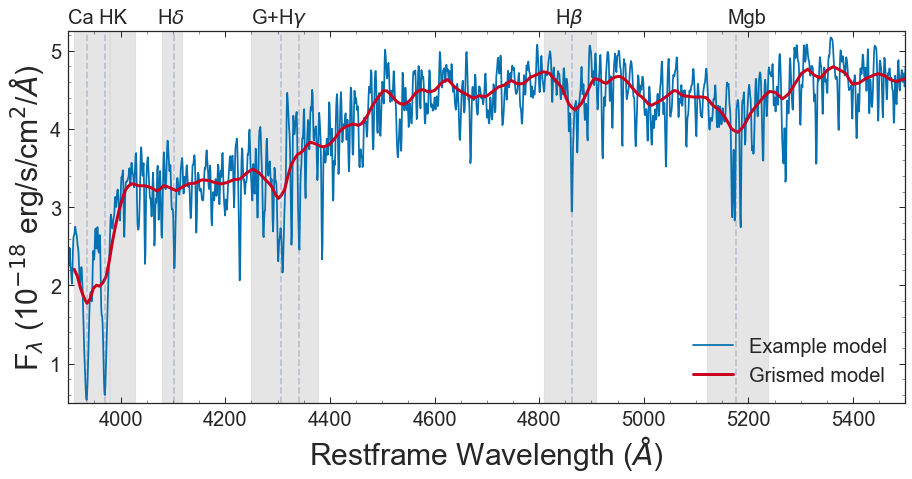

In [9]:
###PLOT###PLOT
%matplotlib inline

# plt.figure(figsize=(12,5))
# plt.plot(spec.gal_wv_rf,spec.fl*1E18, color='#ca0020',
#          label='Grismed model\nZ/Z$_\odot$=%s,\nt=%s Gyrs' % (np.round(galDB['Z_f'][220]/0.019,2),galDB['t_f'][220]))
# plt.axvline(3934.777,linestyle='--', alpha=.3)
# plt.axvline(3969.588,linestyle='--', alpha=.3)
# plt.axvline(4102.89,linestyle='--', alpha=.3)
# plt.axvline(4305.61,linestyle='--', alpha=.3)
# plt.axvline(4341.68,linestyle='--', alpha=.3)
# plt.axvline(4862.68,linestyle='--', alpha=.3)
# plt.axvline(5176.7,linestyle='--', alpha=.3)
# plt.axvspan(3910, 3980, color='k', alpha=.1)
# plt.axvspan(3980, 4030, color='k', alpha=.1)
# plt.axvspan(4080, 4120, color='k', alpha=.1)
# plt.axvspan(4250, 4380, color='k', alpha=.1)
# plt.axvspan(4810, 4910, color='k', alpha=.1)
# plt.axvspan(5120, 5240, color='k', alpha=.1)
# plt.text(3900,5.35,'Ca HK',fontsize=20)
# plt.text(4070,5.35,'H$\delta$',fontsize=20)
# plt.text(4250,5.35,'G+H$\gamma$',fontsize=20)
# plt.text(4830,5.35,'H$\\beta$',fontsize=20)
# plt.text(5160,5.35,'Mgb',fontsize=20)
# plt.xlim(3900,5500)
# plt.ylim(.5,5.25)
# plt.ylabel('F$_\lambda$ (10$^{-18}$ erg/s/cm$^2$/$\AA$)',size=30)
# plt.xlabel('Restframe Wavelength ($\AA$)',size=30)
# plt.tick_params(axis='both', which='major', labelsize=20)
# plt.gcf().subplots_adjust(bottom=0.235)
# plt.legend(loc=4,fontsize=20)
# plt.minorticks_on()
# plt.show()
# # plt.savefig('../plots/s39170_gres_8-4.pdf')
# plt.close()

plt.figure(figsize=(15,8))
plt.plot(wv,fl*1.2E5, color='#0571b0',label='Example model')
plt.plot(spec.gal_wv_rf,spec.fl*1E18, color='#ca0020',label='Grismed model', linewidth=3)
plt.axvline(3934.777,linestyle='--', alpha=.3)
plt.axvline(3969.588,linestyle='--', alpha=.3)
plt.axvline(4102.89,linestyle='--', alpha=.3)
plt.axvline(4305.61,linestyle='--', alpha=.3)
plt.axvline(4341.68,linestyle='--', alpha=.3)
plt.axvline(4862.68,linestyle='--', alpha=.3)
plt.axvline(5176.7,linestyle='--', alpha=.3)
plt.axvspan(3910, 3980, color='k', alpha=.1)
plt.axvspan(3980, 4030, color='k', alpha=.1)
plt.axvspan(4080, 4120, color='k', alpha=.1)
plt.axvspan(4250, 4380, color='k', alpha=.1)
plt.axvspan(4810, 4910, color='k', alpha=.1)
plt.axvspan(5120, 5240, color='k', alpha=.1)
plt.text(3900,5.35,'Ca HK',fontsize=20)
plt.text(4070,5.35,'H$\delta$',fontsize=20)
plt.text(4250,5.35,'G+H$\gamma$',fontsize=20)
plt.text(4830,5.35,'H$\\beta$',fontsize=20)
plt.text(5160,5.35,'Mgb',fontsize=20)
plt.xlim(3900,5500)
plt.ylim(.5,5.25)
plt.ylabel('F$_\lambda$ (10$^{-18}$ erg/s/cm$^2$/$\AA$)',size=30)
plt.xlabel('Restframe Wavelength ($\AA$)',size=30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.gcf().subplots_adjust(bottom=0.235)
plt.legend(loc=4,fontsize=20)
plt.minorticks_on()
plt.show()
# plt.savefig('../plots/s39170_fres_8-4.pdf')
plt.close()

#Simulation Example

In [76]:
###Data 
spec = Gen_sim(galDB['gids'][220],galDB['hi_res_specz'][220],0.019,2.0,8.0,maxwv=11400)
spec.Perturb_flux()
lines = [3934,3969,4102,4305,4341,4862,5176]
regions = [[3910, 3980],[3980, 4030],[4080, 4120],[4250, 4380],[4810, 4910],[5120, 5240]]
txlines = [3900,4070,4250,4830,5160]
text = ['Ca HK','H$\delta$','G+H$\gamma$','H$\\beta$','Mgb']

../data/galaxy_flts/s39170_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39170_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39170_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39170_flt: save ../data/galaxy_flts/s39170_flt.detect_seg.fits, ../data/galaxy_flts/s39170_flt.detect.cat


In [78]:
###Plot
plt.figure(figsize=(15,8))
plt.plot(spec.gal_wv_rf,spec.flx_err*1E18, color='#0571b0',label='Simulated data')
plt.plot(spec.gal_wv_rf,spec.fl*1E18, color='#ca0020',label='Grismed model',linewidth = 3)
[plt.axvline(U,linestyle='--', alpha=.3) for U in lines]   
[plt.axvspan(U[0], U[1], color='k', alpha=.1) for U in regions]   
[plt.text(txlines[U],5.35,text[U],fontsize=20) for U in range(len(txlines))]   
plt.xlim(3900,5650)
plt.ylabel('F$_\lambda$ (10$^{-18}$ erg/s/cm$^2$/$\AA$)',size=30)
plt.xlabel('Restframe Wavelength ($\AA$)',size=30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.gcf().subplots_adjust(bottom=0.235)
plt.legend(loc=4,fontsize=20)
plt.minorticks_on()
# plt.show()
plt.savefig('../plots/simulated_data_10-26.pdf',bbox_inches = 'tight')
plt.close()

#Example Posterior

In [22]:
###DATA
P = np.load('../chidat/n21156_dtau_tZ_pos_lwa.npy')
t,Pt = np.load('../chidat/n21156_dtau_t_pos_lwa.npy')
Z,PZ = np.load('../chidat/n21156_dtau_Z_pos_lwa.npy')
onesig,twosig = Likelihood_contours(age,metal,P)
levels = np.array([twosig,onesig])

In [24]:
###PLOT
gs = gridspec.GridSpec(2,2,height_ratios=[1,4],width_ratios=[4,1],hspace=0,wspace=0)
plt.figure(figsize=[8,8])

plt.subplot(gs[2])
plt.contour(M,A,P,levels,colors='k',linewidths=2)
plt.contourf(M,A,P,40,cmap=cmap)
plt.axis([0,0.03,0,6])
plt.xlabel('Metallicity (Z$_\odot$)',size=35)
plt.ylabel('Light Weighted Age (Gyrs)',size=35)
plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([ 0.00475,  0.0095 ,  0.01425,  0.019  ,  0.02375,  0.0285 ],[0.25,.5,0.75,1.0,1.25,1.5])

plt.subplot(gs[0])
plt.plot(Z,PZ)
plt.xticks([])
plt.yticks([])
plt.xlim(0,0.03)
plt.ylim(0,max(PZ))

plt.subplot(gs[3])
plt.plot(Pt,t)
plt.xticks([])
plt.yticks([])
plt.ylim(0,6)
plt.xlim(0,max(Pt))

# plt.show()
plt.savefig('../plots/n21156_lh_10-17.pdf',bbox_inches = 'tight')
plt.close()

#Spectra and Photometry

In [71]:
###DATA 
phot_db = pd.read_pickle('../data/phot_db.pkl')
smpDB = pd.read_pickle('../data/sim_meas_phot.pkl')
spec = Gen_spec('n21156', 1.251)
Clam = 3E18 / phot_db['eff_wv'] **2 * 10**((-1.1)/2.5-29)
if max(phot_db['n21156']*1E18 * Clam) > max(spec.gal_fl*1E18):
    ymax = max(phot_db['n21156']*1E18 * Clam)
else:
    ymax = max(spec.gal_fl*1E18)

../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat


In [74]:
###PLOT
%matplotlib inline    

plt.figure(figsize=[17,6])
plt.errorbar(spec.gal_wv,spec.gal_fl * 1E18,spec.gal_er * 1E18,fmt='o',color = 'k', ms=2,elinewidth=1,label = 'n21156, z=1.251')

# plt.plot(smpDB['f850-effwv'][61], smpDB['sim-f850'][61] * 1E18,'d',color='#2B4CFF',ms=15)
# plt.plot(smpDB['f098-effwv'][61], smpDB['sim-f098'][61] * 1E18,'d',color='#2B4CFF',ms=15)
# plt.plot(smpDB['f105-effwv'][61], smpDB['sim-f105'][61] * 1E18,'d',color='#2B4CFF',ms=15)

plt.errorbar(phot_db['eff_wv'],phot_db['n21156'] * Clam *1E18 ,phot_db['n21156_err'] * Clam *1E18,
             phot_db['fwhm']/2 ,color='#BC344F',fmt='D',label='GOODS Photometry')
plt.ylim(0,ymax*1.1)
plt.xlim(5800,14000)
plt.minorticks_on()
plt.ylabel('F$_\lambda$ (10$^{-18}$ erg/s/cm$^2$/$\AA$)',size=35)
plt.tick_params(axis='both', which='major', labelsize=25)
plt.xlabel('Observed Frame Wavelength ($\AA$)',size=35)
plt.legend(loc=4,fontsize = 25)
plt.gcf().subplots_adjust(bottom=0.235)
plt.savefig('../plots/n21156_phot_spec.pdf',bbox_inches = 'tight')
# plt.show()
plt.close()

In [47]:
###DATA 
# phot_db = pd.read_pickle('../data/phot_db.pkl').drop('s_F105W')
phot_db = pd.read_pickle('../data/phot_db.pkl')
spec = Gen_spec('s39170', 1.022)
Clam = 3E18 / phot_db['eff_wv'] **2 * 10**((-1.1)/2.5-29)
if max(phot_db['s39170']*1E18 * Clam) > max(spec.gal_fl*1E18):
    ymax = max(phot_db['s39170']*1E18 * Clam)
else:
    ymax = max(spec.gal_fl*1E18)

../data/galaxy_flts/s39170_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39170_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39170_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39170_flt: save ../data/galaxy_flts/s39170_flt.detect_seg.fits, ../data/galaxy_flts/s39170_flt.detect.cat


In [75]:
###PLOT
%matplotlib inline    

plt.figure(figsize=[17,6])
plt.errorbar(spec.gal_wv,spec.gal_fl * 1E18,spec.gal_er * 1E18 * 1.07,fmt='o',color = 'k', ms=2,elinewidth=1,label = 's39170, z=1.022')

# plt.plot(smpDB['f850-effwv'][220], smpDB['sim-f850'][220] * 1E18 * 1.07,'d',color='#2B4CFF',ms=15)
# plt.plot(smpDB['f098-effwv'][220], smpDB['sim-f098'][220] * 1E18 * 1.07,'d',color='#2B4CFF',ms=15)
# plt.plot(smpDB['f105-effwv'][220], smpDB['sim-f105'][220] * 1E18 * 1.07,'d',color='#2B4CFF',ms=15)

plt.errorbar(phot_db['eff_wv'],phot_db['s39170'] * Clam *1E18 ,phot_db['s39170_err'] * Clam *1E18,
             phot_db['fwhm']/2 ,color='#BC344F',fmt='D',zorder=5,label='GOODS Photometry')
plt.ylim(0,ymax*1.1)
plt.xlim(5800,14000)
plt.minorticks_on()
plt.ylabel('F$_\lambda$ (10$^{-18}$ erg/s/cm$^2$/$\AA$)',size=35)
plt.tick_params(axis='both', which='major', labelsize=25)
plt.xlabel('Observed Frame Wavelength ($\AA$)',size=35)
plt.legend(loc=4,fontsize = 25)
plt.gcf().subplots_adjust(bottom=0.235)
plt.savefig('../plots/S39170_phot_spec.pdf',bbox_inches = 'tight')
# plt.show()
plt.close()

In [10]:
###DATA 
phot_db = pd.read_pickle('../data/phot_db.pkl')
smpDB = pd.read_pickle('../data/sim_meas_phot.pkl')
spec = Gen_spec(galDB['gids'][236], galDB['hi_res_specz'][236])
Clam = 3E18 / phot_db['eff_wv'] **2 * 10**((-1.1)/2.5-29)
if max(phot_db[galDB['gids'][236]]*1E18 * Clam) > max(spec.gal_fl*1E18):
    ymax = max(phot_db[galDB['gids'][236]]*1E18 * Clam)
else:
    ymax = max(spec.gal_fl*1E18)

../data/galaxy_flts/s41659_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)


../data/galaxy_flts/s41659_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41659_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s41659_flt: save ../data/galaxy_flts/s41659_flt.detect_seg.fits, ../data/galaxy_flts/s41659_flt.detect.cat


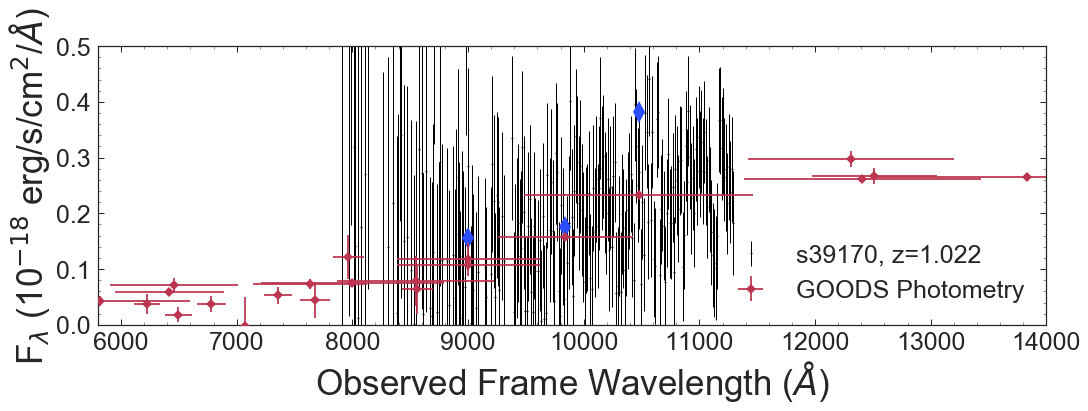

In [12]:
###PLOT
%matplotlib inline    

plt.figure(figsize=[17,6])
plt.errorbar(spec.gal_wv,spec.gal_fl * 1E18,spec.gal_er * 1E18,fmt='o',color = 'k', ms=2,elinewidth=1,label = 's39170, z=1.022')

plt.plot(smpDB['f850-effwv'][236], smpDB['sim-f850'][236] * 1E18,'d',color='#2B4CFF',ms=15)
plt.plot(smpDB['f098-effwv'][236], smpDB['sim-f098'][236] * 1E18,'d',color='#2B4CFF',ms=15)
plt.plot(smpDB['f105-effwv'][236], smpDB['sim-f105'][236] * 1E18,'d',color='#2B4CFF',ms=15)

plt.errorbar(phot_db['eff_wv'],phot_db[galDB['gids'][236]] * Clam *1E18 ,phot_db[galDB['gids'][236] + '_err'] * Clam *1E18,
             phot_db['fwhm']/2 ,color='#BC344F',fmt='D',zorder=5,label='GOODS Photometry')
plt.ylim(0,0.5)
plt.xlim(5800,14000)
plt.minorticks_on()
plt.ylabel('F$_\lambda$ (10$^{-18}$ erg/s/cm$^2$/$\AA$)',size=35)
plt.tick_params(axis='both', which='major', labelsize=25)
plt.xlabel('Observed Frame Wavelength ($\AA$)',size=35)
plt.legend(loc=4,fontsize = 25)
plt.gcf().subplots_adjust(bottom=0.235)
plt.show()
plt.close()

#Age Vs Redshift - 3 feat groups

In [94]:
"""DATA"""

def Bootstrap_errors_vfit(redshifts,ages,ers,its=1000):
    l_grid = np.zeros(its)
    IDs = np.arange(len(redshifts))
    wei = 1 /ers**2
    for i in range(its):
        IDn = np.random.choice(IDs,len(IDs),replace=True)
        # vfit = np.sum(ages[IDn] * wei[[IDn]]) / np.sum(wei[IDn])
        vfit = np.median(ages[IDn])
        l_grid[i] = vfit

    m_val = np.median(l_grid,axis=0)
    low_ers = l_grid.T[150]
    hi_ers = l_grid.T[830]

    return low_ers,hi_ers, m_val

age_range = np.arange(0,3,0.05)
lzDB = galDB.query('hi_res_specz < 1.16')
mzDB = galDB.query('1.16 < hi_res_specz < 1.3')
mzDB = mzDB.query('ids != 14713 and ids != 38126')
hzDB = galDB.query('1.3 < hi_res_specz < 1.45')
uhzDB = galDB.query('1.45 < hi_res_specz')
gmtlDB = galDB.query('ids != 14713 and ids != 38126 and ids != 40597')

Pl,Pm,Ph,Puh = np.ones([4,len(age)])
Pall = np.ones(age_range.size)

for i in lzDB.index:
    t,Pt = np.load('../chidat/%s_dtau_t_pos_lwa.npy' % lzDB['gids'][i])
    Pl = Pl * Pt
    
for i in mzDB.index:
    t,Pt = np.load('../chidat/%s_dtau_t_pos_lwa.npy' % mzDB['gids'][i])
    Pm = Pm * Pt
    
for i in hzDB.index:
    t,Pt = np.load('../chidat/%s_dtau_t_pos_lwa.npy' % hzDB['gids'][i])
    Ph = Ph * Pt
    
for i in uhzDB.index:
    t,Pt = np.load('../chidat/%s_dtau_t_pos_lwa.npy' % uhzDB['gids'][i])
    Puh = Puh * Pt

for i in gmtlDB.index:
    t,Pt = np.load('../chidat/%s_dtau_t_pos_lwa.npy' % gmtlDB['gids'][i])
    rqPall = (Oldest_galaxy(np.median(gmtlDB['hi_res_specz'][i])) - age)
    irqPall = interp1d(rqPall,Pt)(age_range) / np.trapz(interp1d(rqPall,Pt)(age_range),age_range)
    Pall = Pall * irqPall
   
Pl /= np.trapz(Pl,age)
Pm /= np.trapz(Pm,age)
Ph /= np.trapz(Ph,age)
Puh /= np.trapz(Puh,age)
Pall /= np.trapz(Pall,age_range)

lmed,ller,lher=Median_w_Error_cont(Pl,age)
mmed,mler,mher=Median_w_Error_cont(Pm,age)
hmed,hler,hher=Median_w_Error_cont(Ph,age)
uhmed,uhler,uhher=Median_w_Error_cont(Puh,age)

lt=np.array(lzDB['tx_lwa'])
mt=np.array(mzDB['tx_lwa'])
ht=np.array(hzDB['tx_lwa'])
uht=np.array(uhzDB['tx_lwa'])
gmtlt=np.array(gmtlDB['tx_lwa'])

fumx,fumy=Readfile('../data/fumagalli_fig14.dat',0)
d,fverr=Readfile('../data/fumagalli_fig14_verr.dat',0)
fherr,d=Readfile('../data/fumagalli_fig14_herr.dat',0)

verr=np.zeros(len(fverr))
herr=np.zeros(len(fherr))
for i in range(len(verr)):
    verr[i]=np.abs(fverr[i]-fumy[i])
    herr[i]=np.abs(fherr[i]-fumx[i])
    
samp = np.arange(1,1.8,0.01)
 
lerrs = gmtlDB['tx_-_sig_lwa']
herrs = gmtlDB['tx_+_sig_lwa']
errs = (lerrs + herrs)/2
lvals = np.polyfit(gmtlDB['hi_res_specz'],Oldest_galaxy(gmtlDB['hi_res_specz']) - gmtlt, 1, w = 1/errs**2)
lfit = np.polyval(lvals,samp)

low_ers,hi_ers,m_fit = Bootstrap_errors_vfit(gmtlDB['hi_res_specz'].values,Oldest_galaxy(gmtlDB['hi_res_specz']) - gmtlt,errs.values)

In [51]:
###PLOT
%matplotlib inline

z=np.linspace(0,2,100)
ages=[Oldest_galaxy(a) for a in z]

plt.figure(figsize=[12,8])
currentAxis = plt.gca()
plt.plot(z,ages,'k--',alpha=.5)

# plt.errorbar(fumx[0:3],fumy[0:3],xerr=herr[0:3],yerr=verr[0:3]
#              ,color=sea.color_palette('muted')[0],zorder=1,fmt='o',alpha=.5,ms=1,label='Fumagalli+16 BC03')
# plt.errorbar(fumx[3:6],fumy[3:6],xerr=herr[3:6],yerr=verr[3:6]
#              ,color=sea.color_palette('muted')[2],zorder=2,fmt='o',alpha=.5,ms=1,label='Fumagalli+16 FSPS10')
plt.errorbar(fumx[6:9],fumy[6:9],xerr=herr[6:9],yerr=verr[6:9]
             ,color=sea.color_palette('muted')[4],zorder=3,fmt='o',alpha=.5,ms=1,label='Fumagalli+16')
plt.plot(fumx[9],fumy[9],'k^',label='Mendel+15')
plt.plot(fumx[10:14],fumy[10:14],'kp',label='Choi+14')
plt.plot(fumx[14],fumy[14],'kd',label='Gallazzi+14')
plt.plot(fumx[15],fumy[15],'k*',label='Whitaker+13')

plt.errorbar(lzDB['hi_res_specz'],lt,yerr=[lzDB['tx_-_sig_lwa'],lzDB['tx_+_sig_lwa']],color='#e41a1c',alpha=.4,ms=4,fmt='o')
plt.errorbar(mzDB['hi_res_specz'],mt,yerr=[mzDB['tx_-_sig_lwa'],mzDB['tx_+_sig_lwa']],color='#377eb8',alpha=.4,ms=4,fmt='o')
plt.errorbar(hzDB['hi_res_specz'],ht,yerr=[hzDB['tx_-_sig_lwa'],hzDB['tx_+_sig_lwa']],color='#4daf4a',alpha=.4,ms=4,fmt='o')
plt.errorbar(uhzDB['hi_res_specz'],uht,yerr=[uhzDB['tx_-_sig_lwa'],uhzDB['tx_+_sig_lwa']],color='#984ea3',alpha=.4,ms=4,fmt='o')

plt.errorbar(np.median(lzDB['hi_res_specz']),lmed,yerr=[[ller,lher]], color='#e41a1c',ms=11,fmt='o',label='z~1.1')
plt.errorbar(np.median(mzDB['hi_res_specz']),mmed,yerr=[[mler,mher]], color='#377eb8',ms=11,fmt='D',label='z~1.2')
plt.errorbar(np.median(hzDB['hi_res_specz']),hmed,yerr=[[hler,hher]], color='#4daf4a',ms=11,fmt='s',label='z~1.3')
plt.errorbar(np.median(uhzDB['hi_res_specz']),uhmed,yerr=[[uhler,uhher]], color='#984ea3',ms=11,fmt='^',label='z~1.6')

plt.axis([0.,2.0,0,7])
# plt.axis([0.9,1.8,0,7])
plt.xlabel('Redshift (z)',size=30)
plt.ylabel('Age (Gyrs)',size=30)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()
plt.text(1.3,4.9,'Age of the Universe',rotation=-22,fontsize=22)
plt.gcf().subplots_adjust(bottom=0.16)
plt.legend(fontsize=15)
# plt.show()
plt.savefig('../plots/agevz_featgroup_all_dt_10-17.pdf',bbox_inches = 'tight')
plt.close()

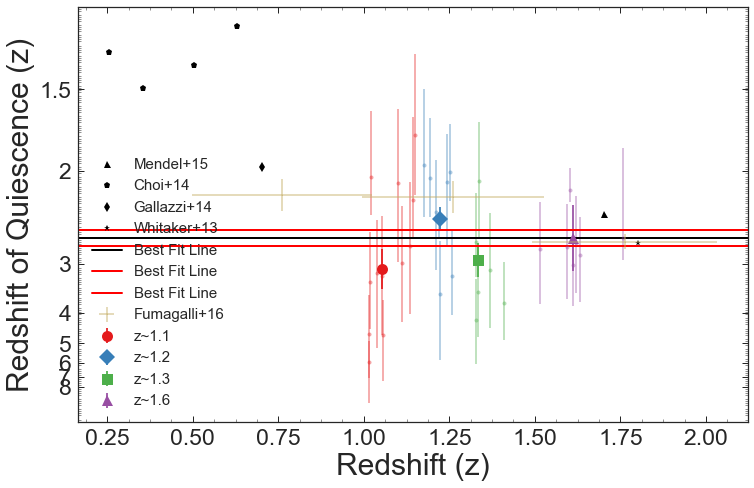

In [99]:
###PLOT
%matplotlib inline

z=np.linspace(0,2,100)
ages=[Oldest_galaxy(a) for a in z]

plt.figure(figsize=[12,8])
currentAxis = plt.gca()
# plt.plot(z,ages,'k--',alpha=.5)

plt.errorbar(fumx[6:9],Oldest_galaxy(fumx[6:9]) - fumy[6:9],xerr=herr[6:9],yerr=verr[6:9]
             ,color=sea.color_palette('muted')[4],zorder=3,fmt='o',alpha=.5,ms=1,label='Fumagalli+16')
plt.plot(fumx[9], Oldest_galaxy(fumx[9]) - fumy[9],'k^',label='Mendel+15')
plt.plot(fumx[10:14],Oldest_galaxy(fumx[10:14]) - fumy[10:14],'kp',label='Choi+14')
plt.plot(fumx[14],Oldest_galaxy(fumx[14]) - fumy[14],'kd',label='Gallazzi+14')
plt.plot(fumx[15],Oldest_galaxy(fumx[15]) - fumy[15],'k*',label='Whitaker+13')

plt.errorbar(lzDB['hi_res_specz'], Oldest_galaxy(lzDB['hi_res_specz']) - lt,
             yerr=[lzDB['tx_-_sig_dt'],lzDB['tx_+_sig_dt']],color='#e41a1c',alpha=.4,ms=4,fmt='o')
plt.errorbar(mzDB['hi_res_specz'],Oldest_galaxy(mzDB['hi_res_specz']) - mt,
             yerr=[mzDB['tx_-_sig_dt'],mzDB['tx_+_sig_dt']],color='#377eb8',alpha=.4,ms=4,fmt='o')
plt.errorbar(hzDB['hi_res_specz'],Oldest_galaxy(hzDB['hi_res_specz']) - ht,
             yerr=[hzDB['tx_-_sig_dt'],hzDB['tx_+_sig_dt']],color='#4daf4a',alpha=.4,ms=4,fmt='o')
plt.errorbar(uhzDB['hi_res_specz'],Oldest_galaxy(uhzDB['hi_res_specz']) - uht,
             yerr=[uhzDB['tx_-_sig_dt'],uhzDB['tx_+_sig_dt']],color='#984ea3',alpha=.4,ms=4,fmt='o')

plt.errorbar(np.median(lzDB['hi_res_specz']), Oldest_galaxy(np.median(lzDB['hi_res_specz'])) - lmed,
             yerr=[[ller,lher]], color='#e41a1c',ms=11,fmt='o',label='z~1.1')
plt.errorbar(np.median(mzDB['hi_res_specz']), Oldest_galaxy(np.median(mzDB['hi_res_specz'])) - mmed,
             yerr=[[mler,mher]], color='#377eb8',ms=11,fmt='D',label='z~1.2')
plt.errorbar(np.median(hzDB['hi_res_specz']), Oldest_galaxy(np.median(hzDB['hi_res_specz'])) - hmed,
             yerr=[[hler,hher]], color='#4daf4a',ms=11,fmt='s',label='z~1.3')
plt.errorbar(np.median(uhzDB['hi_res_specz']), Oldest_galaxy(np.median(uhzDB['hi_res_specz'])) - uhmed,
             yerr=[[uhler,uhher]], color='#984ea3',ms=11,fmt='^',label='z~1.6')
(2.4593186372745492, 0.094589178356713433, 0.10641282565130261)
plt.axhline(2.4593186372745492,color = 'k',linewidth=2,label ='Best Fit Line')
plt.axhline(2.4593186372745492- 0.094589178356713433,color = 'r',linewidth=2,label ='Best Fit Line')
plt.axhline(2.4593186372745492+0.10641282565130261,color = 'r',linewidth=2,label ='Best Fit Line')
# plt.plot(samp,lfit,'b',linewidth=2,label ='Fit Line')
# plt.fill_between(samp,low_ers,hi_ers,alpha = .2,label = '68% Conifidence Interval')

plt.xlabel('Redshift (z)',size=30)
plt.ylabel('Redshift of Quiescence (z)',size=30)
plt.yticks([0.6389,0.76245,0.9315,1.1735,1.5413,2.1489,3.2845,4.278],[8,7,6,5,4,3,2,1.5])
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()
plt.gcf().subplots_adjust(bottom=0.16)
# plt.legend(fontsize=23)
plt.legend(loc=3,fontsize=15)
plt.show()
# plt.savefig('../plots/agevz_rshift_all_dt_10-17.pdf',bbox_inches = 'tight')
plt.close()

(2.4593186372745492, 0.094589178356713433, 0.10641282565130261)


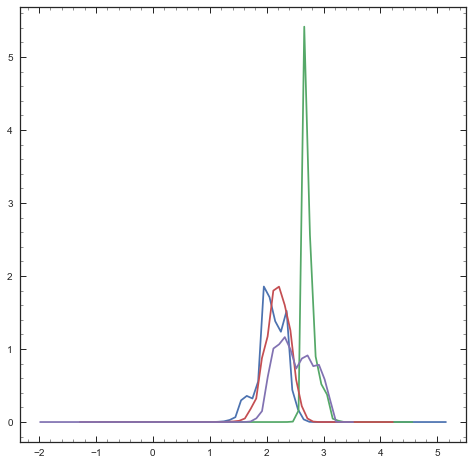

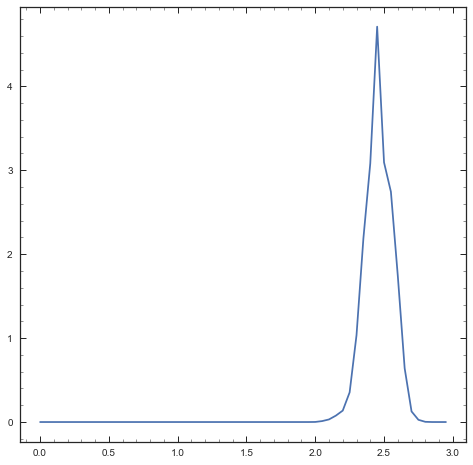

In [96]:
plt.figure(figsize=[8,8])
plt.plot(Oldest_galaxy(np.median(lzDB['hi_res_specz'])) - age,Pl)
plt.plot(Oldest_galaxy(np.median(mzDB['hi_res_specz'])) - age,Pm)
plt.plot(Oldest_galaxy(np.median(hzDB['hi_res_specz'])) - age,Ph)
plt.plot(Oldest_galaxy(np.median(uhzDB['hi_res_specz'])) - age,Puh)


plt.figure(figsize=[8,8])
plt.plot(age_range,Pall)
print Median_w_Error_cont(Pall,age_range)

In [81]:
rqagel = (Oldest_galaxy(np.median(lzDB['hi_res_specz'])) - age)
rqagem = (Oldest_galaxy(np.median(mzDB['hi_res_specz'])) - age)
rqageh = (Oldest_galaxy(np.median(hzDB['hi_res_specz'])) - age)
rqageuh = (Oldest_galaxy(np.median(uhzDB['hi_res_specz'])) - age)

age_range = np.arange(0,3.5,0.05)

irqPl = interp1d(rqagel,Pl)(age_range) / np.trapz(interp1d(rqagel,Pl)(age_range),age_range)
irqPm = interp1d(rqagem,Pm)(age_range)/ np.trapz(interp1d(rqagem,Pm)(age_range),age_range)
irqPh = interp1d(rqageh,Ph)(age_range)/ np.trapz(interp1d(rqageh,Ph)(age_range),age_range)
irqPuh = interp1d(rqageuh,Puh)(age_range)/ np.trapz(interp1d(rqageuh,Puh)(age_range),age_range)


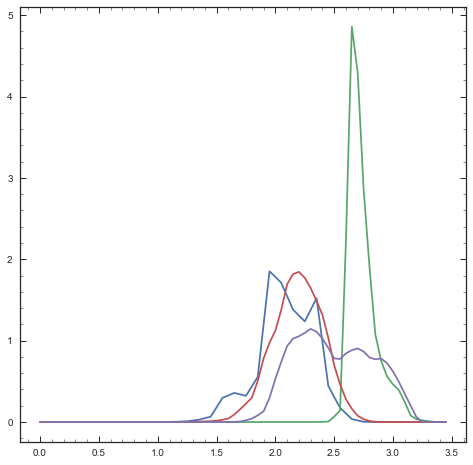

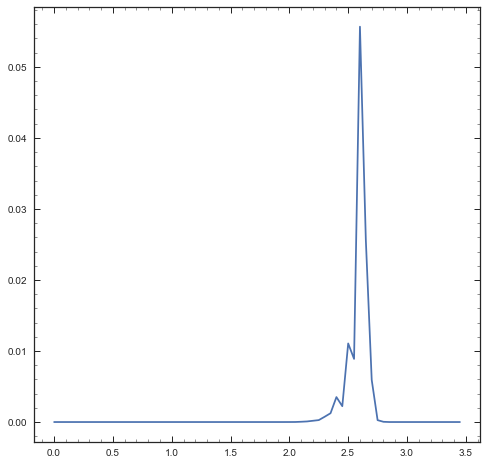

In [82]:
plt.figure(figsize=[8,8])
plt.plot(age_range,irqPl)
plt.plot(age_range,irqPm)
plt.plot(age_range,irqPh)
plt.plot(age_range,irqPuh)

plt.figure(figsize=[8,8])
plt.plot(age_range,irqPl * irqPm * irqPh * irqPuh)

In [ ]:
###PLOT
%matplotlib inline

z=np.linspace(0,2,100)
ages=[Oldest_galaxy(a) for a in z]

plt.figure(figsize=[12,8])
currentAxis = plt.gca()

plt.errorbar(lzDB['hi_res_specz'], Oldest_galaxy(lzDB['hi_res_specz']) - lt,
             yerr=[lzDB['tx_-_sig_dt'],lzDB['tx_+_sig_dt']],color='#e41a1c',alpha=.4,ms=4,fmt='o')
plt.errorbar(mzDB['hi_res_specz'],Oldest_galaxy(mzDB['hi_res_specz']) - mt,
             yerr=[mzDB['tx_-_sig_dt'],mzDB['tx_+_sig_dt']],color='#377eb8',alpha=.4,ms=4,fmt='o')
plt.errorbar(hzDB['hi_res_specz'],Oldest_galaxy(hzDB['hi_res_specz']) - ht,
             yerr=[hzDB['tx_-_sig_dt'],hzDB['tx_+_sig_dt']],color='#4daf4a',alpha=.4,ms=4,fmt='o')
plt.errorbar(uhzDB['hi_res_specz'],Oldest_galaxy(uhzDB['hi_res_specz']) - uht,
             yerr=[uhzDB['tx_-_sig_dt'],uhzDB['tx_+_sig_dt']],color='#984ea3',alpha=.4,ms=4,fmt='o')

plt.errorbar(np.median(lzDB['hi_res_specz']), Oldest_galaxy(np.median(lzDB['hi_res_specz'])) - lmed,
             yerr=[[ller,lher]], color='#e41a1c',ms=11,fmt='o',label='z~1.1')
plt.errorbar(np.median(mzDB['hi_res_specz']), Oldest_galaxy(np.median(mzDB['hi_res_specz'])) - mmed,
             yerr=[[mler,mher]], color='#377eb8',ms=11,fmt='D',label='z~1.2')
plt.errorbar(np.median(hzDB['hi_res_specz']), Oldest_galaxy(np.median(hzDB['hi_res_specz'])) - hmed,
             yerr=[[hler,hher]], color='#4daf4a',ms=11,fmt='s',label='z~1.3')
plt.errorbar(np.median(uhzDB['hi_res_specz']), Oldest_galaxy(np.median(uhzDB['hi_res_specz'])) - uhmed,
             yerr=[[uhler,uhher]], color='#984ea3',ms=11,fmt='^',label='z~1.6')

# plt.axis([0.9,1.7,0,7])
plt.xlabel('Redshift (z)',size=30)
plt.ylabel('Redshift of Quiescence (z)',size=30)
plt.yticks([0.6389,0.76245,0.9315,1.1735,1.5413,2.1489,3.2845,4.278],[8,7,6,5,4,3,2,1.5])
plt.tick_params(axis='both', which='major', labelsize=17)
plt.minorticks_on()
plt.gcf().subplots_adjust(bottom=0.16)
plt.legend(loc=4,fontsize=23)
# plt.show()
plt.savefig('../plots/delta_age_featgroup_dt_9-4.pdf')
plt.close()


In [54]:
# [0.6389,0.76245,0.9315,1.1735,1.5413,2.1489,3.2845,4.278],[8,7,6,5,4,3,2,1.5]

print  Oldest_galaxy(0) * u.Gyr -Planck13.lookback_time(2.6)

2.51193246402 Gyr


#Mass Metallcity - feat group

In [15]:
"""DATA"""
def Bootstrap_errors(data_list):
    its = 1000
    bs_medians = np.zeros(its)
    for i in range(its):
        new_sample = np.random.choice(data_list,len(data_list),replace=True)
        bs_medians[i] = np.median(new_sample)
    return np.std(bs_medians)

def Bootstrap_errors_lfit(masses,metals,ers,sampling=np.arange(10,11.75,.01),its=1000):
    l_grid = np.zeros([its,len(sampling)])
    IDs = np.arange(len(masses))
    for i in range(its):
        IDn = np.random.choice(IDs,len(IDs),replace=True)
        lvals = np.polyfit(masses[IDn],np.log10(metals[IDn]/.019),1,w = 1/ers[IDn]**2)
        lfit = np.polyval(lvals,sampling)
        l_grid[i] = lfit
        
    m_fit = np.mean(l_grid,axis=0)
    low_ers = np.zeros(len(samp))
    hi_ers = np.zeros(len(samp))
    
    for i in range(len(l_grid.T)):
        low_ers[i] = np.sort(l_grid.T[i])[150]
        hi_ers[i] = np.sort(l_grid.T[i])[830]
    return low_ers,hi_ers, m_fit

lzDB = galDB.query('hi_res_specz < 1.16')
mzDB = galDB.query('1.16 < hi_res_specz < 1.3')
mzDB = mzDB.query('ids != 14713 and ids != 38126')
hzDB = galDB.query('1.3 < hi_res_specz < 1.45')
uhzDB = galDB.query('1.45 < hi_res_specz')
# uhzDB = uhzDB.query('ids != 41148 and ids != 44042')
gmtlDB = galDB.query('1.45 > hi_res_specz')
gmtlDB = gmtlDB.query('ids != 14713 and ids != 38126')



Pl,Pm,Ph,Puh = np.ones([4,len(metal)])

for i in lzDB.index:
    Z,PZ = np.load('../chidat/%s_dtau_Z_pos_lwa.npy' % lzDB['gids'][i])
    Pl = Pl * PZ
    
for i in mzDB.index:
    Z,PZ = np.load('../chidat/%s_dtau_Z_pos_lwa.npy' % mzDB['gids'][i])
    Pm = Pm * PZ
    
for i in hzDB.index:
    Z,PZ = np.load('../chidat/%s_dtau_Z_pos_lwa.npy' % hzDB['gids'][i])
    Ph = Ph * PZ
    
for i in uhzDB.index:
    Z,PZ = np.load('../chidat/%s_dtau_Z_pos_lwa.npy' % uhzDB['gids'][i])
    Puh = Puh * PZ
    
Pl /= np.trapz(Pl,metal)
Pm /= np.trapz(Pm,metal)
Ph /= np.trapz(Ph,metal)
Puh /= np.trapz(Puh,metal)

lmed,ller,lher=Median_w_Error_cont(Pl,metal)
mmed,mler,mher=Median_w_Error_cont(Pm,metal)
hmed,hler,hher=Median_w_Error_cont(Ph,metal)
uhmed,uhler,uhher=Median_w_Error_cont(Puh,metal)

logm,gmetal=Readfile('../data/Gallazzi_12.dat',0)
cvx,cvy=Readfile('../data/Gallazzi_12_line.dat',0)
cv1x,cv1y=Readfile('../data/gallazzi_points_curve1.dat',0)

lZ=np.array(lzDB['Zx_lwa'])
mZ=np.array(mzDB['Zx_lwa'])
hZ=np.array(hzDB['Zx_lwa'])
uhZ=np.array(uhzDB['Zx_lwa'])
gmtlZ=np.array(gmtlDB['Zx_lwa'])

LMASS = robjects.FloatVector(gmtlDB['lmass'])
LZS = robjects.FloatVector(np.log10(gmtlZ/.019))

lerrs = gmtlDB['Zx_-_sig_lwa']/(gmtlDB['Zx_lwa'] * np.log(10))
herrs = gmtlDB['Zx_+_sig_lwa']/(gmtlDB['Zx_lwa'] * np.log(10))
# errs = (lerrs + herrs)/2
errs = (gmtlDB['Zx_-_sig_lwa'] + gmtlDB['Zx_+_sig_lwa']/2) / (gmtlDB['Zx_lwa'] * np.log(10))
lvals = np.polyfit(gmtlDB['lmass'],np.log10(gmtlZ/.019),1,w = 1/errs**2)
lfit = np.polyval(lvals,np.arange(10,11.75,.01))

samp = np.arange(10,11.75,.01)
low_ers,hi_ers,m_fit = Bootstrap_errors_lfit(gmtlDB['lmass'].values,gmtlZ,errs.values,sampling=samp)

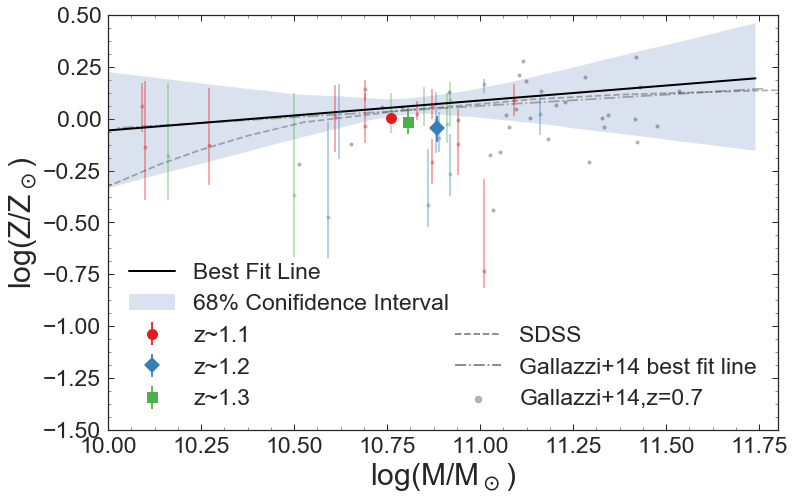

In [16]:
###PLOT
%matplotlib inline

plt.figure(figsize=[12,8])
currentAxis = plt.gca()

####gallazzi points
plt.plot(cv1x,cv1y,'--',zorder=1,color='k',alpha=.3,markersize=4)
sdss=plt.axhline(y=5,linestyle='--',color='k',alpha=.5)
plt.plot(cvx,cvy,zorder=2,linestyle='-.',color='k',alpha=.3,ms=4)
galbf=plt.axhline(y=5,linestyle='-.',color='k',alpha=.5)
plt.plot(logm,gmetal,'o',zorder=3,color='k',alpha=.3,markersize=4)
galpts = plt.scatter(100,100,marker='o',zorder=3,color='k',alpha=.3)#,label='Gallazzi+14,z=0.7')
legend1 = plt.legend([sdss,galbf,galpts],['SDSS','Gallazzi+14 best fit line','Gallazzi+14,z=0.7'],loc = 4,fontsize=23)
currentAxis.add_artist(legend1)
#####single galaxy points

lerrs = gmtlDB['Zx_-_sig_dt']/(gmtlDB['Zx_dt'] * np.log(10))
herrs = gmtlDB['Zx_+_sig_dt']/(gmtlDB['Zx_dt'] * np.log(10))
errs = np.sqrt(lerrs**2 + herrs**2)
lvals = np.polyfit(gmtlDB['lmass'],np.log10(gmtlZ/.019),1,w = 1/lerrs**2)
lfit = np.polyval(lvals,np.arange(10,11.75,.01))
#'#e41a1c' '#377eb8' '#4daf4a' '#984ea3'


plt.errorbar(lzDB['lmass'],np.log10(lZ/0.019), yerr=[lzDB['Zx_-_sig_dt']/(lzDB['Zx_dt'] * np.log(10)),lzDB['Zx_+_sig_dt']/(lzDB['Zx_dt'] * np.log(10))]
             ,color='#e41a1c',alpha=.4,ms=4,fmt='o')
plt.errorbar(mzDB['lmass'],np.log10(mZ/0.019), yerr=[mzDB['Zx_-_sig_dt']/(mzDB['Zx_dt'] * np.log(10)),mzDB['Zx_+_sig_dt']/(mzDB['Zx_dt'] * np.log(10))]
             ,color='#377eb8',alpha=.4,ms=4,fmt='o')
plt.errorbar(hzDB['lmass'],np.log10(hZ/0.019), yerr=[hzDB['Zx_-_sig_dt']/(hzDB['Zx_dt'] * np.log(10)),hzDB['Zx_+_sig_dt']/(hzDB['Zx_dt'] * np.log(10))]
             ,color='#4daf4a',alpha=.4,ms=4,fmt='o')
plt.plot(samp,m_fit,'k',linewidth=2,label ='Best Fit Line')
# plt.plot(samp,low_ers,'k--',linewidth = .5,label = 'Boot strap errors')
# plt.plot(samp,hi_ers,'k--',linewidth = .5)
plt.fill_between(samp,low_ers,hi_ers,alpha = .2,label = '68% Conifidence Interval')

plt.errorbar(np.median(lzDB['lmass']),np.log10(lmed/0.019), yerr=[[ller/(lmed * np.log(10))],[lher/(lmed * np.log(10))]],
             color='#e41a1c',ms=11,fmt='o',label='z~1.1')
plt.errorbar(np.median(mzDB['lmass']),np.log10(mmed/0.019),  yerr=[[mler/(mmed * np.log(10))],[mher/(mmed * np.log(10))]],
             color='#377eb8',ms=11,fmt='D',label='z~1.2')
plt.errorbar(np.median(hzDB['lmass']),np.log10(hmed/0.019),  yerr=[[hler/(hmed * np.log(10))],[hher/(hmed * np.log(10))]],
             color='#4daf4a',ms=11,fmt='s',label='z~1.3')
# plt.errorbar(np.median(uhzDB['lmass']),np.log10(uhmed/0.019), xerr=bser_uhz, yerr=np.log10([[uhmed/(uhmed-uhler)],[uhher/uhmed+1]]),
#              color='#2AA104',ms=8,fmt='s',label='z~1.6')


plt.xlabel('log(M/M$_\odot$)',size=30)
plt.ylabel('log(Z/Z$_\odot$)',size=30)
plt.axis([10,11.8,-1.5,.5])
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()

plt.gcf().subplots_adjust(bottom=0.16)
plt.legend(fontsize=23)
plt.show()
# plt.savefig('../plots/metalmass_featgroup_10-17.pdf',bbox_inches = 'tight')
plt.close()

In [106]:
###PLOT
%matplotlib inline
gs = gridspec.GridSpec(2,2,hspace=0.12,wspace=0.05)
plt.figure(figsize=[16,10])
#'#e41a1c' '#377eb8' '#4daf4a' '#984ea3'
#### low z
ax1 = plt.subplot(gs[0,0])
plt.plot(cv1x,cv1y,'--',zorder=1,color='k',alpha=.6,markersize=4)
plt.plot(cvx,cvy,zorder=2,color='k',alpha=.6,ms=4)
plt.plot(logm,gmetal,'o',zorder=3,color='k',alpha=.8,markersize=4)
plt.errorbar(lzDB['lmass'],np.log10(lZ/0.019), yerr=np.log10([(lzDB['Zx_f']/(lzDB['Zx_f']-lzDB['Zx_-_sig_f'])),
                            (lzDB['Zx_+_sig_f']/lzDB['Zx_f']+1)]),color='#e41a1c',alpha=1,ms=5,fmt='o')
plt.errorbar(np.median(lzDB['lmass']),np.log10(lmed/0.019), yerr=np.log10([[lmed/(lmed-ller)],[lher/lmed+1]]),
             color='#e41a1c',ms=14,fmt='o',label='z~1.1')
plt.ylabel('log(Z/Z$_\odot$)',size=30)
ax1.xaxis.tick_top()
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
plt.axis([10,11.8,-1.0,.5])
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()
plt.gcf().subplots_adjust(bottom=0.16)
plt.legend(fontsize=23)

#### mid z
ax2 = plt.subplot(gs[0,1])
plt.plot(cv1x,cv1y,'--',zorder=1,color='k',alpha=.6,markersize=4)
plt.plot(cvx,cvy,zorder=2,color='k',alpha=.6,ms=4)
plt.plot(logm,gmetal,'o',zorder=3,color='k',alpha=.8,markersize=4)
plt.errorbar(mzDB['lmass'],np.log10(mZ/0.019), yerr=np.log10([(mzDB['Zx_f']/(mzDB['Zx_f']-mzDB['Zx_-_sig_f'])),
                            (mzDB['Zx_+_sig_f']/mzDB['Zx']+1)]),color='#377eb8',alpha=1,ms=5,fmt='o')
plt.errorbar(np.median(mzDB['lmass']),np.log10(mmed/0.019), yerr=np.log10([[mmed/(mmed-mler)],[mher/mmed+1]]),
             color='#377eb8',ms=14,fmt='D',label='z~1.2')
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.yaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both')
plt.axis([10,11.8,-1.0,.5])
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()
plt.gcf().subplots_adjust(bottom=0.16)
plt.legend(fontsize=23)

#### high z
ax3 = plt.subplot(gs[1,0])
plt.plot(cv1x,cv1y,'--',zorder=1,color='k',alpha=.6,markersize=4)
plt.plot(cvx,cvy,zorder=2,color='k',alpha=.6,ms=4)
plt.plot(logm,gmetal,'o',zorder=3,color='k',alpha=.8,markersize=4)
plt.errorbar(hzDB['lmass'],np.log10(hZ/0.019), yerr=np.log10([(hzDB['Z']/(hzDB['Zx']-hzDB['Zx_-_sig_f'])),
                            (hzDB['Zx_+_sig_f']/hzDB['Zx']+1)]),color='#4daf4a',alpha=1,ms=5,fmt='o')
plt.errorbar(np.median(hzDB['lmass']),np.log10(hmed/0.019), yerr=np.log10([[hmed/(hmed-hler)],[hher/hmed+1]]),
             color='#4daf4a',ms=14,fmt='s',label='z~1.3')
plt.xlabel('log(M/M$_\odot$)',size=30)
plt.ylabel('log(Z/Z$_\odot$)',size=30)
ax3.yaxis.set_ticks_position('both')
ax3.xaxis.set_ticks_position('both')
plt.axis([10,11.8,-1.0,.5])
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()
plt.gcf().subplots_adjust(bottom=0.16)
plt.legend(fontsize=23)

#### u high z
ax4 = plt.subplot(gs[1,1])
plt.plot(cv1x,cv1y,'--',zorder=1,color='k',alpha=.6,markersize=4)
plt.plot(cvx,cvy,zorder=2,color='k',alpha=.6,ms=4)
plt.plot(logm,gmetal,'o',zorder=3,color='k',alpha=.8,markersize=4)
plt.errorbar(uhzDB['lmass'],np.log10(uhZ/0.019), yerr=np.log10([(uhzDB['Zx_f']/(uhzDB['Zx_f']-uhzDB['Zx_-_sig_f'])),
                            (uhzDB['Zx_+_sig_f']/uhzDB['Zx_f']+1)]),color='#984ea3',alpha=1,ms=5,fmt='o')
plt.errorbar(np.median(uhzDB['lmass']),np.log10(uhmed/0.019), yerr=np.log10([[uhmed/(uhmed-uhler)],[uhher/uhmed+1]]),
             color='#984ea3',ms=14,fmt='^',label='z~1.6')
plt.xlabel('log(M/M$_\odot$)',size=30)
# plt.ylabel('log(Z/Z$_\odot$)',size=30)
ax4.yaxis.tick_right()
ax4.yaxis.set_ticks_position('both')
ax4.xaxis.set_ticks_position('both')
plt.axis([10,11.8,-1.0,.5])
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()
plt.gcf().subplots_adjust(bottom=0.16)
plt.legend(fontsize=23)
# plt.show()
plt.savefig('../plots/metalmass_featgroup_splot_7-20.pdf')
plt.close()

#3 Stack best fits, Feat group

In [101]:
"""DATA"""
lzDB = galDB.query('hi_res_specz < 1.16')
mzDB = galDB.query('1.16 < hi_res_specz < 1.3')
mzDB = mzDB.query('ids != 14713 and ids != 38126')
hzDB = galDB.query('1.3 < hi_res_specz < 1.45')
uhzDB = galDB.query('1.45 < hi_res_specz')

PZl, PZm, PZh, PZuh = np.ones([4,len(metal)])
PTl, PTm, PTh, PTuh = np.ones([4,len(age)])

for i in lzDB.index:
    z, pz = np.load('../chidat/%s_dtau_Z_pos_lwa.npy' % lzDB['gids'][i])
    t, pt = np.load('../chidat/%s_dtau_t_pos_lwa.npy' % lzDB['gids'][i])
    PZl = PZl * pz
    PTl = PTl * pt
    
for i in mzDB.index:
    z, pz = np.load('../chidat/%s_dtau_Z_pos_lwa.npy' % mzDB['gids'][i])
    t, pt = np.load('../chidat/%s_dtau_t_pos_lwa.npy' % mzDB['gids'][i])
    PZm = PZm * pz
    PTm = PTm * pt
    
for i in hzDB.index:
    z, pz = np.load('../chidat/%s_dtau_Z_pos_lwa.npy' % hzDB['gids'][i])
    t, pt = np.load('../chidat/%s_dtau_t_pos_lwa.npy' % hzDB['gids'][i])
    PZh = PZh * pz
    PTh = PTh * pt

for i in uhzDB.index:
    z, pz = np.load('../chidat/%s_dtau_Z_pos_lwa.npy' % uhzDB['gids'][i])
    t, pt = np.load('../chidat/%s_dtau_t_pos_lwa.npy' % uhzDB['gids'][i])
    PZuh = PZuh * pz
    PTuh = PTuh * pt

PZl /= np.trapz(PZl, metal)
PZm /= np.trapz(PZm, metal)
PZh /= np.trapz(PZh, metal)
PZuh /= np.trapz(PZuh, metal)
PTl /= np.trapz(PTl, age)
PTm /= np.trapz(PTm, age)
PTh /= np.trapz(PTh, age)
PTuh /= np.trapz(PTuh, age)

Zmedl, Zler, Zher = Median_w_Error(PZl, metal)
Zmedm, Zler, Zher = Median_w_Error(PZm, metal)
Zmedh, Zler, Zher = Median_w_Error(PZh, metal)
Zmeduh, Zler, Zher = Median_w_Error(PZuh, metal)
tmedl, tler, ther = Median_w_Error(PTl, age)
tmedm, tler, ther = Median_w_Error(PTm, age)
tmedh, tler, ther = Median_w_Error(PTh, age)
tmeduh, tler, ther = Median_w_Error(PTuh, age)

lzstack = Stack(lzDB['gids'].values,lzDB['hi_res_specz'].values,np.arange(3400,5300,10),np.arange(3950,5200,1))
lzstack.Stack_normwmean()
lzstack.Stack_normwmean_model(Zmedl,tmedl,tau,bftau=0)

mzstack = Stack(mzDB['gids'].values,mzDB['hi_res_specz'].values,np.arange(3400,5300,10),np.arange(3650,4950,1))
mzstack.Stack_normwmean()
mzstack.Stack_normwmean_model(Zmedm,tmedm,tau,bftau=8.0)

hzstack = Stack(hzDB['gids'].values,hzDB['hi_res_specz'].values,np.arange(3400,5300,10),np.arange(3450,4550,1))
hzstack.Stack_normwmean()
hzstack.Stack_normwmean_model(Zmedh,tmedh,tau,bftau=8.3)

uhzstack = Stack(uhzDB['gids'].values,uhzDB['hi_res_specz'].values,np.arange(3300,5300,10),np.arange(3400,4000,1))
uhzstack.Stack_normwmean()
uhzstack.Stack_normwmean_model(Zmeduh,tmeduh,tau,bftau=8.0)

../data/galaxy_flts/n16758_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n16758_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n16758_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n16758_flt: save ../data/galaxy_flts/n16758_flt.detect_seg.fits, ../data/galaxy_flts/n16758_flt.detect.cat


../data/galaxy_flts/n19442_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n19442_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n19442_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n19442_flt: save ../data/galaxy_flts/n19442_flt.detect_seg.fits, ../data/galaxy_flts/n19442_flt.detect.cat


../data/galaxy_flts/n23435_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n23435_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n23435_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n23435_flt: save ../data/galaxy_flts/n23435_flt.detect_seg.fits, ../data/galaxy_flts/n23435_flt.detect.cat


../data/galaxy_flts/n32566_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n32566_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n32566_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n32566_flt: save ../data/galaxy_flts/n32566_flt.detect_seg.fits, ../data/galaxy_flts/n32566_flt.detect.cat


../data/galaxy_flts/n34694_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n34694_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n34694_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n34694_flt: save ../data/galaxy_flts/n34694_flt.detect_seg.fits, ../data/galaxy_flts/n34694_flt.detect.cat


../data/galaxy_flts/s39170_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39170_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39170_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39170_flt: save ../data/galaxy_flts/s39170_flt.detect_seg.fits, ../data/galaxy_flts/s39170_flt.detect.cat


../data/galaxy_flts/s39241_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39241_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39241_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39241_flt: save ../data/galaxy_flts/s39241_flt.detect_seg.fits, ../data/galaxy_flts/s39241_flt.detect.cat


../data/galaxy_flts/s39631_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39631_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39631_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39631_flt: save ../data/galaxy_flts/s39631_flt.detect_seg.fits, ../data/galaxy_flts/s39631_flt.detect.cat


../data/galaxy_flts/s43615_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s43615_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s43615_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s43615_flt: save ../data/galaxy_flts/s43615_flt.detect_seg.fits, ../data/galaxy_flts/s43615_flt.detect.cat


../data/galaxy_flts/s45972_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s45972_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s45972_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s45972_flt: save ../data/galaxy_flts/s45972_flt.detect_seg.fits, ../data/galaxy_flts/s45972_flt.detect.cat


../data/galaxy_flts/s47677_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s47677_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s47677_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s47677_flt: save ../data/galaxy_flts/s47677_flt.detect_seg.fits, ../data/galaxy_flts/s47677_flt.detect.cat


../data/galaxy_flts/s48631_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s48631_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s48631_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s48631_flt: save ../data/galaxy_flts/s48631_flt.detect_seg.fits, ../data/galaxy_flts/s48631_flt.detect.cat


../data/galaxy_flts/n16758_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n16758_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n16758_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n16758_flt: save ../data/galaxy_flts/n16758_flt.detect_seg.fits, ../data/galaxy_flts/n16758_flt.detect.cat


../data/galaxy_flts/n19442_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n19442_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n19442_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n19442_flt: save ../data/galaxy_flts/n19442_flt.detect_seg.fits, ../data/galaxy_flts/n19442_flt.detect.cat


../data/galaxy_flts/n23435_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n23435_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n23435_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n23435_flt: save ../data/galaxy_flts/n23435_flt.detect_seg.fits, ../data/galaxy_flts/n23435_flt.detect.cat


../data/galaxy_flts/n32566_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n32566_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n32566_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n32566_flt: save ../data/galaxy_flts/n32566_flt.detect_seg.fits, ../data/galaxy_flts/n32566_flt.detect.cat


../data/galaxy_flts/n34694_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n34694_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n34694_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n34694_flt: save ../data/galaxy_flts/n34694_flt.detect_seg.fits, ../data/galaxy_flts/n34694_flt.detect.cat


../data/galaxy_flts/s39170_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39170_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39170_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39170_flt: save ../data/galaxy_flts/s39170_flt.detect_seg.fits, ../data/galaxy_flts/s39170_flt.detect.cat


../data/galaxy_flts/s39241_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39241_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39241_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39241_flt: save ../data/galaxy_flts/s39241_flt.detect_seg.fits, ../data/galaxy_flts/s39241_flt.detect.cat


../data/galaxy_flts/s39631_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39631_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39631_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39631_flt: save ../data/galaxy_flts/s39631_flt.detect_seg.fits, ../data/galaxy_flts/s39631_flt.detect.cat


../data/galaxy_flts/s43615_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s43615_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s43615_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s43615_flt: save ../data/galaxy_flts/s43615_flt.detect_seg.fits, ../data/galaxy_flts/s43615_flt.detect.cat


../data/galaxy_flts/s45972_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s45972_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s45972_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s45972_flt: save ../data/galaxy_flts/s45972_flt.detect_seg.fits, ../data/galaxy_flts/s45972_flt.detect.cat


../data/galaxy_flts/s47677_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s47677_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s47677_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s47677_flt: save ../data/galaxy_flts/s47677_flt.detect_seg.fits, ../data/galaxy_flts/s47677_flt.detect.cat


../data/galaxy_flts/s48631_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s48631_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s48631_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s48631_flt: save ../data/galaxy_flts/s48631_flt.detect_seg.fits, ../data/galaxy_flts/s48631_flt.detect.cat


../data/galaxy_flts/n17070_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n17070_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n17070_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n17070_flt: save ../data/galaxy_flts/n17070_flt.detect_seg.fits, ../data/galaxy_flts/n17070_flt.detect.cat


../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat


../data/galaxy_flts/n37686_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n37686_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n37686_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n37686_flt: save ../data/galaxy_flts/n37686_flt.detect_seg.fits, ../data/galaxy_flts/n37686_flt.detect.cat


../data/galaxy_flts/s35774_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s35774_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s35774_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s35774_flt: save ../data/galaxy_flts/s35774_flt.detect_seg.fits, ../data/galaxy_flts/s35774_flt.detect.cat


../data/galaxy_flts/s38785_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s38785_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s38785_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s38785_flt: save ../data/galaxy_flts/s38785_flt.detect_seg.fits, ../data/galaxy_flts/s38785_flt.detect.cat


../data/galaxy_flts/s39805_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39805_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39805_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39805_flt: save ../data/galaxy_flts/s39805_flt.detect_seg.fits, ../data/galaxy_flts/s39805_flt.detect.cat


../data/galaxy_flts/s40476_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40476_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40476_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40476_flt: save ../data/galaxy_flts/s40476_flt.detect_seg.fits, ../data/galaxy_flts/s40476_flt.detect.cat


../data/galaxy_flts/s40597_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40597_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40597_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40597_flt: save ../data/galaxy_flts/s40597_flt.detect_seg.fits, ../data/galaxy_flts/s40597_flt.detect.cat


../data/galaxy_flts/n17070_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n17070_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n17070_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n17070_flt: save ../data/galaxy_flts/n17070_flt.detect_seg.fits, ../data/galaxy_flts/n17070_flt.detect.cat


../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat


../data/galaxy_flts/n37686_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n37686_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n37686_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n37686_flt: save ../data/galaxy_flts/n37686_flt.detect_seg.fits, ../data/galaxy_flts/n37686_flt.detect.cat


../data/galaxy_flts/s35774_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s35774_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s35774_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s35774_flt: save ../data/galaxy_flts/s35774_flt.detect_seg.fits, ../data/galaxy_flts/s35774_flt.detect.cat


../data/galaxy_flts/s38785_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s38785_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s38785_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s38785_flt: save ../data/galaxy_flts/s38785_flt.detect_seg.fits, ../data/galaxy_flts/s38785_flt.detect.cat


../data/galaxy_flts/s39805_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39805_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39805_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39805_flt: save ../data/galaxy_flts/s39805_flt.detect_seg.fits, ../data/galaxy_flts/s39805_flt.detect.cat


../data/galaxy_flts/s40476_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40476_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40476_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40476_flt: save ../data/galaxy_flts/s40476_flt.detect_seg.fits, ../data/galaxy_flts/s40476_flt.detect.cat


../data/galaxy_flts/s40597_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40597_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40597_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40597_flt: save ../data/galaxy_flts/s40597_flt.detect_seg.fits, ../data/galaxy_flts/s40597_flt.detect.cat


../data/galaxy_flts/s39804_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39804_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39804_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39804_flt: save ../data/galaxy_flts/s39804_flt.detect_seg.fits, ../data/galaxy_flts/s39804_flt.detect.cat


../data/galaxy_flts/s40623_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40623_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40623_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40623_flt: save ../data/galaxy_flts/s40623_flt.detect_seg.fits, ../data/galaxy_flts/s40623_flt.detect.cat


../data/galaxy_flts/s40862_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40862_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40862_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40862_flt: save ../data/galaxy_flts/s40862_flt.detect_seg.fits, ../data/galaxy_flts/s40862_flt.detect.cat


../data/galaxy_flts/s44620_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44620_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44620_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44620_flt: save ../data/galaxy_flts/s44620_flt.detect_seg.fits, ../data/galaxy_flts/s44620_flt.detect.cat


../data/galaxy_flts/s46066_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46066_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46066_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46066_flt: save ../data/galaxy_flts/s46066_flt.detect_seg.fits, ../data/galaxy_flts/s46066_flt.detect.cat


../data/galaxy_flts/s46345_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46345_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46345_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46345_flt: save ../data/galaxy_flts/s46345_flt.detect_seg.fits, ../data/galaxy_flts/s46345_flt.detect.cat


../data/galaxy_flts/s39804_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39804_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39804_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39804_flt: save ../data/galaxy_flts/s39804_flt.detect_seg.fits, ../data/galaxy_flts/s39804_flt.detect.cat


../data/galaxy_flts/s40623_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40623_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40623_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40623_flt: save ../data/galaxy_flts/s40623_flt.detect_seg.fits, ../data/galaxy_flts/s40623_flt.detect.cat


../data/galaxy_flts/s40862_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40862_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40862_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40862_flt: save ../data/galaxy_flts/s40862_flt.detect_seg.fits, ../data/galaxy_flts/s40862_flt.detect.cat


../data/galaxy_flts/s44620_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44620_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44620_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44620_flt: save ../data/galaxy_flts/s44620_flt.detect_seg.fits, ../data/galaxy_flts/s44620_flt.detect.cat


../data/galaxy_flts/s46066_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46066_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46066_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46066_flt: save ../data/galaxy_flts/s46066_flt.detect_seg.fits, ../data/galaxy_flts/s46066_flt.detect.cat


../data/galaxy_flts/s46345_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46345_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46345_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46345_flt: save ../data/galaxy_flts/s46345_flt.detect_seg.fits, ../data/galaxy_flts/s46345_flt.detect.cat


../data/galaxy_flts/n21427_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21427_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21427_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21427_flt: save ../data/galaxy_flts/n21427_flt.detect_seg.fits, ../data/galaxy_flts/n21427_flt.detect.cat


../data/galaxy_flts/s39012_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39012_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39012_flt: photutils.source_properties - 5 objects
../data/galaxy_flts/s39012_flt: save ../data/galaxy_flts/s39012_flt.detect_seg.fits, ../data/galaxy_flts/s39012_flt.detect.cat


../data/galaxy_flts/s40223_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40223_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40223_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40223_flt: save ../data/galaxy_flts/s40223_flt.detect_seg.fits, ../data/galaxy_flts/s40223_flt.detect.cat


../data/galaxy_flts/s41148_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41148_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41148_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41148_flt: save ../data/galaxy_flts/s41148_flt.detect_seg.fits, ../data/galaxy_flts/s41148_flt.detect.cat


../data/galaxy_flts/s41520_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41520_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41520_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41520_flt: save ../data/galaxy_flts/s41520_flt.detect_seg.fits, ../data/galaxy_flts/s41520_flt.detect.cat


../data/galaxy_flts/s41659_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41659_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41659_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s41659_flt: save ../data/galaxy_flts/s41659_flt.detect_seg.fits, ../data/galaxy_flts/s41659_flt.detect.cat


../data/galaxy_flts/s44042_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44042_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44042_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44042_flt: save ../data/galaxy_flts/s44042_flt.detect_seg.fits, ../data/galaxy_flts/s44042_flt.detect.cat


../data/galaxy_flts/n21427_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21427_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21427_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21427_flt: save ../data/galaxy_flts/n21427_flt.detect_seg.fits, ../data/galaxy_flts/n21427_flt.detect.cat


../data/galaxy_flts/s39012_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39012_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39012_flt: photutils.source_properties - 5 objects
../data/galaxy_flts/s39012_flt: save ../data/galaxy_flts/s39012_flt.detect_seg.fits, ../data/galaxy_flts/s39012_flt.detect.cat


../data/galaxy_flts/s40223_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40223_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40223_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40223_flt: save ../data/galaxy_flts/s40223_flt.detect_seg.fits, ../data/galaxy_flts/s40223_flt.detect.cat


../data/galaxy_flts/s41148_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41148_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41148_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41148_flt: save ../data/galaxy_flts/s41148_flt.detect_seg.fits, ../data/galaxy_flts/s41148_flt.detect.cat


../data/galaxy_flts/s41520_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41520_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41520_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41520_flt: save ../data/galaxy_flts/s41520_flt.detect_seg.fits, ../data/galaxy_flts/s41520_flt.detect.cat


../data/galaxy_flts/s41659_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41659_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41659_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s41659_flt: save ../data/galaxy_flts/s41659_flt.detect_seg.fits, ../data/galaxy_flts/s41659_flt.detect.cat


../data/galaxy_flts/s44042_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44042_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44042_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44042_flt: save ../data/galaxy_flts/s44042_flt.detect_seg.fits, ../data/galaxy_flts/s44042_flt.detect.cat


In [116]:
"""PLOT"""
def Plot_stack_2(wv,fl,er,mwv,mfl,bfm,bfa,adist,mdist,window=[],group='',save_plot=False,plot_name=''):
    
    gs = gridspec.GridSpec(2,2,hspace=.5,wspace=0,height_ratios=[3,1])
    
    plt.figure(figsize=[15,8])
    plt.subplot(gs[0,0:])
    plt.errorbar(wv,fl * 1000,er * 1000,color='#0571b0',fmt='o',ms = 4,elinewidth=2)
    plt.plot(mwv,mfl * 1000,color='#ca0020',label='Z=%s Z$_\odot$,t=%s' % (np.round(bfm/0.019,2),bfa),zorder = 5,linewidth = 2)
    plt.axvline(3934.777,linestyle='--', alpha=.3)
    plt.axvline(3969.588,linestyle='--', alpha=.3)
    plt.axvline(4102.89,linestyle='--', alpha=.3)
    plt.axvline(4305.61,linestyle='--', alpha=.3)
    plt.axvline(4341.68,linestyle='--', alpha=.3)
    plt.axvline(4862.68,linestyle='--', alpha=.3)
    plt.axvline(5176.7,linestyle='--', alpha=.3)
    plt.axvspan(3910, 3980, color='k', alpha=.1)
    plt.axvspan(3980, 4030, color='k', alpha=.1)
    plt.axvspan(4080, 4120, color='k', alpha=.1)
    plt.axvspan(4250, 4380, color='k', alpha=.1)
    plt.axvspan(4810, 4910, color='k', alpha=.1)
    plt.axvspan(5120, 5240, color='k', alpha=.1)
    plt.text(3900,window[3]+.05,'Ca HK',fontsize=15)
    plt.text(4080,window[3]+.05,'H$\delta$',fontsize=15)
    plt.text(4280,window[3]+.05,'G+H$\gamma$',fontsize=15)
    plt.text(window[0] + 50,window[3] - .15,group,fontsize=25)
    
    if window[1] > 4800:
        plt.text(4830,window[3]+.05,'H$\\beta$',fontsize=15)
    if window[1] > 5100:
        plt.text(5160,window[3]+.05,'Mgb',fontsize=15)
    
    plt.axis(window)
    plt.ylabel('F$_\lambda$',size=20)
    plt.xlabel('Restframe Wavelength ($\AA$)',size=20)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.gcf().subplots_adjust(bottom=0.235)
    plt.legend(loc=4,fontsize=20)
    plt.minorticks_on()
        
    plt.subplot(gs[1,0])
    plt.plot(age,adist,label = 'P(t)')
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.xlim(min(age),max(age))
    plt.xlabel('Age (Gyrs)',size=20)
    plt.yticks([])
    plt.legend(fontsize=15)
    
    plt.subplot(gs[1,1])
    plt.plot(metal,mdist,label = 'P(Z)')
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.xticks([0.00475, 0.0095, 0.01425, 0.019, 0.02375, 0.0285],
           np.round(np.array([0.00475, 0.0095, 0.01425, 0.019, 0.02375, 0.0285])/0.019, 2))    
    plt.xlabel('Metallicity (Z$_\odot$)',size=20)
    plt.xlim(min(metal),max(metal))
    plt.yticks([])
    plt.legend(fontsize=15)
    
    if save_plot == True:
        plt.savefig(plot_name,bbox_inches = 'tight')
    else:
        plt.show()
    plt.close()

In [107]:
print lzstack.bfmetal,lzstack.bfage, lzstack.bftau
print mzstack.bfmetal,mzstack.bfage, mzstack.bftau
print hzstack.bfmetal,hzstack.bfage, hzstack.bftau
print uhzstack.bfmetal,uhzstack.bfage, uhzstack.bftau

0.02 3.6 0
0.018 2.4 8.0
0.019 2.6 8.3
0.03 1.6 8.0


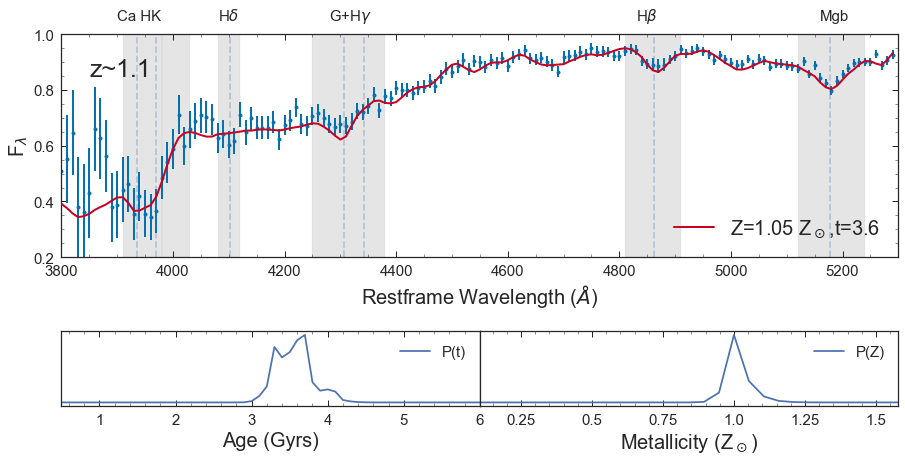

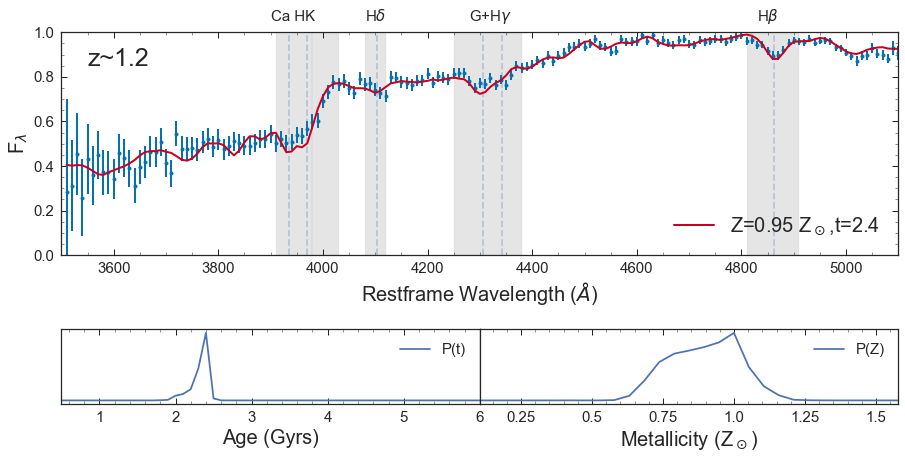

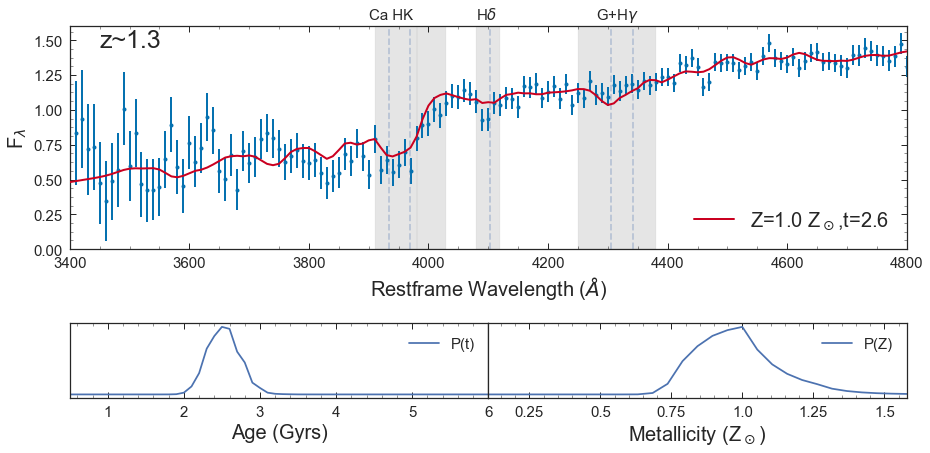

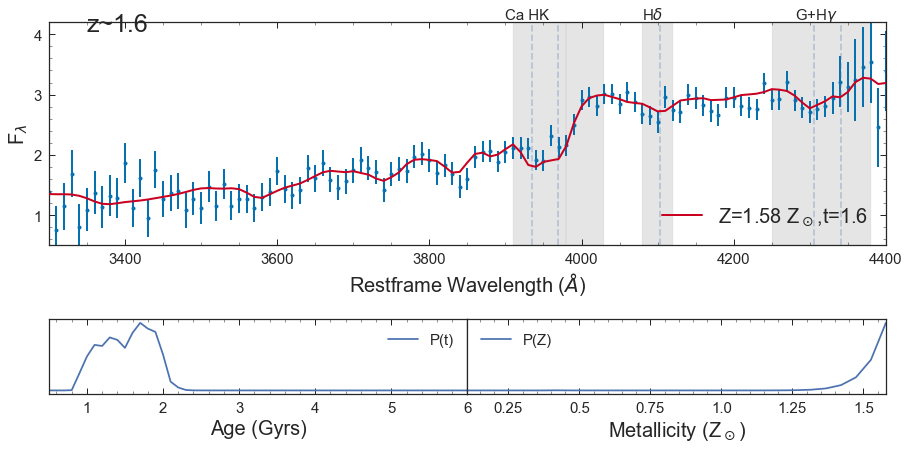

In [117]:
%matplotlib inline

Plot_stack_2(lzstack.wv,lzstack.fl,lzstack.er,lzstack.mwv,lzstack.mfl,0.02,3.6,PTl,PZl,
           window=[3800,5300,.2,1.],group='z~1.1',save_plot=False,plot_name='../plots/stack_lz_bf_10-17.png')

Plot_stack_2(mzstack.wv,mzstack.fl,mzstack.er,mzstack.mwv,mzstack.mfl,0.018,2.4,PTm,PZm,
           window=[3500,5100,0,1.],group='z~1.2',save_plot=False,plot_name='../plots/stack_mz_bf_10-17.png')

Plot_stack_2(hzstack.wv,hzstack.fl,hzstack.er,hzstack.mwv,hzstack.mfl,0.019,2.6,PTh,PZh,
           window=[3400,4800,0,1.6],group='z~1.3',save_plot=False,plot_name='../plots/stack_hz_bf_10-17.png')

Plot_stack_2(uhzstack.wv,uhzstack.fl,uhzstack.er,uhzstack.mwv,uhzstack.mfl,0.03,1.6,PTuh,PZuh,
           window=[3300,4400,0.5,4.2],group='z~1.6',save_plot=False,plot_name='../plots/stack_uhz_bf_10-17.png')

#Fitting Technique Compare

In [64]:
"""DATA"""
mp = [0.005,0.007,0.011,0.013,0.017,0.019,0.021,0.023,0.025,0.027,]
ap = [3.2,2.2,3.8,2.7,4.4,3.2,1.9,5.2,3.6,2.0]

mwc,awc = np.array([[],[]])
mnc,anc = np.array([[],[]])

for i in range(len(mp)):
    mdf1,adf1 = np.load('../mcerr/s39170_m%s_a%s_meth.npy' % (mp[i],ap[i]))
    mwc = np.append(mwc,mdf1 - mp[i])
    awc = np.append(awc,adf1 - ap[i])
    
    mdf1,adf1 = np.load('../mcerr/n21156_m%s_a%s_meth.npy' % (mp[i],ap[i]))
    mwc = np.append(mwc,mdf1 - mp[i])
    awc = np.append(awc,adf1 - ap[i])
    
    mdf1,adf1 = np.load('../mcerr/s40862_m%s_a%s_meth.npy' % (mp[i],ap[i]))
    mwc = np.append(mwc,mdf1 - mp[i])
    awc = np.append(awc,adf1 - ap[i])
    
    mdf1,adf1 = np.load('../mcerr/s44042_m%s_a%s_meth.npy' % (mp[i],ap[i]))
    mwc = np.append(mwc,mdf1 - mp[i])
    awc = np.append(awc,adf1 - ap[i])
    
    mdf1,adf1 = np.load('../mcerr/s39170_m%s_a%s_methNC.npy' % (mp[i],ap[i]))
    mnc = np.append(mnc,mdf1 - mp[i])
    anc = np.append(anc,adf1 - ap[i])
    
    mdf1,adf1 = np.load('../mcerr/n21156_m%s_a%s_methNC.npy' % (mp[i],ap[i]))
    mnc = np.append(mnc,mdf1 - mp[i])
    anc = np.append(anc,adf1 - ap[i])
    
    mdf1,adf1 = np.load('../mcerr/s40862_m%s_a%s_methNC.npy' % (mp[i],ap[i]))
    mnc = np.append(mnc,mdf1 - mp[i])
    anc = np.append(anc,adf1 - ap[i])
    
    mdf1,adf1 = np.load('../mcerr/s44042_m%s_a%s_methNC.npy' % (mp[i],ap[i]))
    mnc = np.append(mnc,mdf1 - mp[i])
    anc = np.append(anc,adf1 - ap[i])

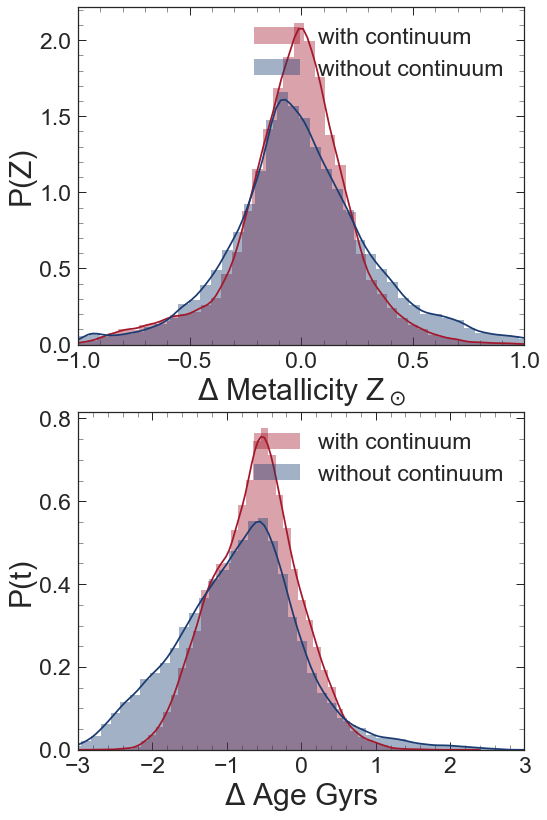

In [66]:
"""PLOT"""
%matplotlib inline

gs = gridspec.GridSpec(2,1)

plt.figure(figsize=[8,16])
plt.subplot(gs[0])
sea.distplot(mwc/0.019,color = '#A3182B',label='with continuum')
sea.distplot(mnc/0.019,color = '#1A3C72',label='without continuum')
plt.xlabel('$\Delta$ Metallicity Z$_\odot$',fontsize = 30)
plt.ylabel('P(Z)',fontsize = 30)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.gcf().subplots_adjust(bottom=0.235)
plt.legend(fontsize=23)
plt.xlim(-1,1)
plt.minorticks_on()
# plt.show()
# plt.savefig('../plots/P-z_2cases.png')
# plt.close()

# plt.figure(figsize=[8,8])
plt.subplot(gs[1])
sea.distplot(awc,color = '#A3182B',label='with continuum')
sea.distplot(anc,color = '#1A3C72',label='without continuum')
plt.xlabel('$\Delta$ Age Gyrs',fontsize = 30)
plt.ylabel('P(t)',fontsize = 30)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.gcf().subplots_adjust(bottom=0.235)
plt.legend(fontsize=23)
plt.xlim(-3,3)
plt.minorticks_on()
plt.show()
# plt.savefig('../plots/P-Zt_2cases.pdf')
plt.close()

#Fitting Technique Compare - Likelihoods

In [102]:
"""DATA"""
tmlist,talist = np.load('../mcerr/s44042_m0.019_a4.5.npy')
ncmlist,ncalist = np.load('../mcerr/s44042_m0.019_a4.5NC.npy')

In [103]:
"""PLOTS""" # same data as above
%matplotlib inline
colmap = sea.cubehelix_palette(12, start=3, rot=0.5, dark=0.1, light=.5, as_cmap=True)

Mlist =np.array([ncmlist,tmlist])
Alist = np.array([ncalist,talist])
pltnames = ['nc_LH.png','t_LH.png']

for i in range(len(Mlist)):
    plt.figure(figsize=[10,8])
    plt.plot(Mlist[i]/.019,Alist[i],'o',alpha=.3,ms=4)
    sea.kdeplot(Mlist[i]/.019,Alist[i],n_levels=2,cmap=colmap)
    plt.plot(0.019/.019,4.5,'rp',ms=10,label='Given parameters')
    plt.axis([0.0/.019,.03/.019,0,6])
    plt.xlabel('Metallicity (Z/Z$_\odot$)',fontsize = 30)
    plt.ylabel('Age (Gyr)',fontsize = 30)
    # plt.title('Continuum',fontsize = 20)
    plt.tick_params(axis='both', which='major', labelsize=23)
    plt.legend(loc=4,fontsize=23)
    plt.minorticks_on()
    # plt.show()
    plt.savefig('../plots/' + pltnames[i])
    plt.close()

#Redshift group comparison

In [37]:
"""DATA"""
mp = np.arange(0.005,0.029,0.002)
ap = [3.2,2.2,1.0,3.8,2.7,1.4,4.4,3.2,1.9,5.2,3.6,2.0]

ms39,as39 = np.array([[],[]])
mn21,an21 = np.array([[],[]])
ms40,as40 = np.array([[],[]])
ms44,as44 = np.array([[],[]])


for i in range(len(mp)):
    mdf1,adf1 = np.load('../mcerr/MC_s39170-m%s_a%s_lwa.npy' % (mp[i],ap[i]))
    ms39 = np.append(ms39,mdf1 - mp[i])
    as39 = np.append(as39,adf1 - ap[i])
    
    mdf1,adf1 = np.load('../mcerr/MC_n21156-m%s_a%s_lwa.npy' % (mp[i],ap[i]))
    mn21 = np.append(mn21,mdf1 - mp[i])
    an21 = np.append(an21,adf1 - ap[i])
    
    mdf1,adf1 = np.load('../mcerr/MC_s40862-m%s_a%s_lwa.npy' % (mp[i],ap[i]))
    ms40 = np.append(ms40,mdf1 - mp[i])
    as40 = np.append(as40,adf1 - ap[i])
    
    mdf1,adf1 = np.load('../mcerr/MC_s44042-m%s_a%s_lwa.npy' % (mp[i],ap[i]))
    ms44 = np.append(ms44,mdf1 - mp[i])
    as44 = np.append(as44,adf1 - ap[i])

In [44]:
print np.median(ms39/.019)
print np.median(mn21/.019)
print np.median(ms40/.019)
print np.median(ms44/.019)

print np.median(as39)
print np.median(an21)
print np.median(as40)
print np.median(as44)

-0.032591498787
-0.0321696023626
-0.0363885666069
-0.0353338255458
-0.256920173681
-0.322576653307
-0.101806028724
-0.29533750835


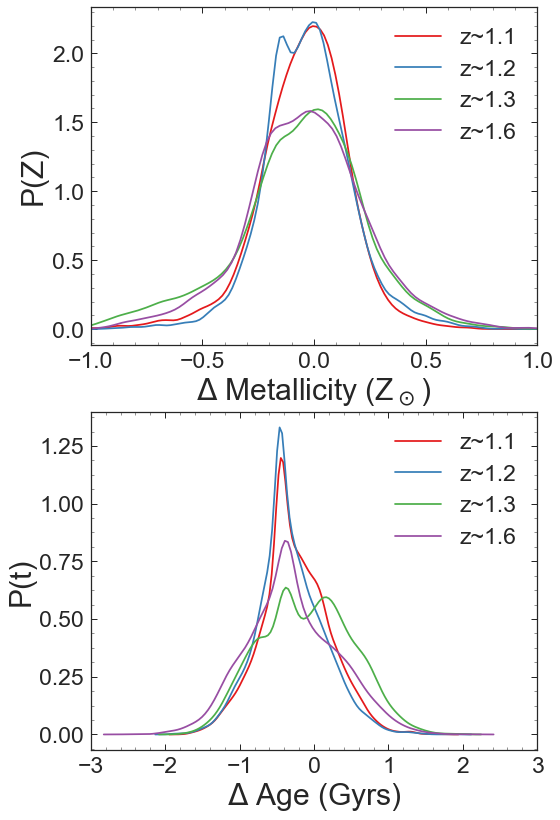

In [41]:
"""PLOT"""
%matplotlib inline
gs = gridspec.GridSpec(2,1)
plt.figure(figsize=[8,16])
plt.subplot(gs[0])
sea.distplot(ms39/.019,color='#e41a1c',hist=False,label='z~1.1')
sea.distplot(mn21/.019,color='#377eb8',hist=False,label='z~1.2')
sea.distplot(ms40/.019,color='#4daf4a',hist=False,label='z~1.3')
sea.distplot(ms44/.019,color='#984ea3',hist=False,label='z~1.6')
plt.xlabel('$\Delta$ Metallicity (Z$_\odot$)',fontsize = 30)
plt.ylabel('P(Z)',fontsize = 30)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.gcf().subplots_adjust(bottom=0.235)
plt.legend(fontsize=23)
plt.xlim(-1,1)
# plt.show()
# plt.savefig('../plots/groups_Z.png')
# plt.close()

# plt.figure(figsize=[8,8])
plt.subplot(gs[1])
sea.distplot(as39,color='#e41a1c',hist=False,label='z~1.1')
sea.distplot(an21,color='#377eb8',hist=False,label='z~1.2')
sea.distplot(as40,color='#4daf4a',hist=False,label='z~1.3')
sea.distplot(as44,color='#984ea3',hist=False,label='z~1.6')
plt.xlabel('$\Delta$ Age (Gyrs)',fontsize = 30)
plt.ylabel('P(t)',fontsize = 30)
plt.tick_params(axis='both', which='major', labelsize=23)
# plt.gcf().subplots_adjust(bottom=0.235)
plt.legend(fontsize=23)
plt.xlim(-3,3)
plt.show()
# plt.savefig('../plots/groups_Zt.pdf')
plt.close()

#Data plot

In [3]:
%matplotlib inline

img1=fits.open('../../../Clear_data/extractions_nov_22/ERSPRIME/ERSPRIME-19-122-G102_39170.2D.fits')
img2=fits.open('../../../Clear_data/extractions_nov_22/ERSPRIME/ERSPRIME-21-092-G102_39170.2D.fits')
img3=fits.open('../../../Clear_data/extractions_nov_22/ERSPRIME/ERSPRIME-22-142-G102_39170.2D.fits')

print img1.info()

Filename: ../../../Clear_data/extractions_nov_22/ERSPRIME/ERSPRIME-19-122-G102_39170.2D.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU      36   ()      
  1  DSCI        ImageHDU        51   (36, 36)   float64   
  2  DINTER      ImageHDU        51   (36, 36)   float64   
  3  DWHT        ImageHDU        51   (36, 36)   float32   
  4  DSEG        ImageHDU        51   (36, 36)   int32   
  5  SCI         ImageHDU        52   (360, 36)   float64   
  6  WHT         ImageHDU        53   (360, 36)   float64   
  7  MODEL       ImageHDU        53   (360, 36)   float64   
  8  CONTAM      ImageHDU        53   (360, 36)   float64   
  9  WAVE        ImageHDU        52   (360,)   float64   
 10  SENS        ImageHDU        53   (360,)   float64   
 11  YTRACE      ImageHDU        53   (360,)   float64   


None


In [ ]:
field.info()

Filename: ../../Grizlsim/s39170_cmb_flt.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU     282   ()              
1    SCI         ImageHDU        58   (1614, 1614)   float32   
2    ERR         ImageHDU        58   (1614, 1614)   float32   
3    DQ          ImageHDU        58   (1614, 1614)   int64   


In [96]:
%matplotlib inline

# plt.figure(figsize=[12,4])
plt.imshow(np.arcsinh(img1['DSCI'].data[::-1]),vmin = 0)
# plt.imshow(np.arcsinh(img1['SCI'].data[::-1,60:330] - img1['CONTAM'].data[::-1,60:330]),vmin = 0)
plt.yticks([])
plt.xticks([])
plt.savefig('../plots/s39170_dir1.eps',format = 'eps',dpi = 72)
# plt.show()
plt.close()

# plt.figure(figsize=[12,4])
plt.imshow(np.arcsinh(img2['DSCI'].data[::-1]),vmin = 0)
# plt.imshow(np.arcsinh((img2['SCI'].data[::-1,60:330] - img2['CONTAM'].data[::-1,60:330])),vmin = 0)
plt.yticks([])
plt.xticks([])
plt.savefig('../plots/s39170_dir2.eps',format = 'eps',dpi = 72)
# plt.show()
plt.close()
# 
# plt.figure(figsize=[12,4])
plt.imshow(np.arcsinh(img3['DSCI'].data[::-1]),vmin = 0)
# plt.imshow(np.arcsinh((img3['SCI'].data[::-1,60:330] - img3['CONTAM'].data[::-1,60:330])),vmin = 0)
plt.yticks([])
plt.xticks([])
plt.savefig('../plots/s39170_dir3.eps',format = 'eps',dpi = 72)
# plt.show()
plt.close()

#Photometry plots

In [151]:
###DATA
smpDB = pd.read_pickle('../data/sim_meas_phot.pkl')
smpDB = smpDB[smpDB['gal_ids'] != 's35774']
f098DB = smpDB[smpDB['meas-f098'] > 0]
f850DB = smpDB[smpDB['meas-f850'] > 0]
f105DB = smpDB[smpDB['meas-f105'] > 0]

def Magnitude(flam):
    mag=-2.5*np.log10(flam)
    return mag

Clam = 3E18 / 10475.92199 **2 * 10**((-1.1)/2.5-29)

SNr = []

for i in f098DB.index:
    spec = Gen_spec(f098DB['gal_ids'][i], float(galDB['hi_res_specz'][galDB['gids'] == f098DB['gal_ids'][i]]),maxwv=11400)
    fl = np.trapz(spec.gal_fl,spec.gal_wv)
    er = np.trapz(spec.gal_er,spec.gal_wv)
    SNr.append(fl/er)

../data/galaxy_flts/s38785_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s38785_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s38785_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s38785_flt: save ../data/galaxy_flts/s38785_flt.detect_seg.fits, ../data/galaxy_flts/s38785_flt.detect.cat


../data/galaxy_flts/s39012_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)


../data/galaxy_flts/s39012_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39012_flt: photutils.source_properties - 5 objects
../data/galaxy_flts/s39012_flt: save ../data/galaxy_flts/s39012_flt.detect_seg.fits, ../data/galaxy_flts/s39012_flt.detect.cat


../data/galaxy_flts/s39170_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39170_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39170_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39170_flt: save ../data/galaxy_flts/s39170_flt.detect_seg.fits, ../data/galaxy_flts/s39170_flt.detect.cat


../data/galaxy_flts/s39241_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39241_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39241_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39241_flt: save ../data/galaxy_flts/s39241_flt.detect_seg.fits, ../data/galaxy_flts/s39241_flt.detect.cat


../data/galaxy_flts/s39631_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39631_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39631_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39631_flt: save ../data/galaxy_flts/s39631_flt.detect_seg.fits, ../data/galaxy_flts/s39631_flt.detect.cat


../data/galaxy_flts/s39804_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39804_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39804_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39804_flt: save ../data/galaxy_flts/s39804_flt.detect_seg.fits, ../data/galaxy_flts/s39804_flt.detect.cat


../data/galaxy_flts/s39805_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39805_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/s39805_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39805_flt: save ../data/galaxy_flts/s39805_flt.detect_seg.fits, ../data/galaxy_flts/s39805_flt.detect.cat


../data/galaxy_flts/s40223_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40223_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40223_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40223_flt: save ../data/galaxy_flts/s40223_flt.detect_seg.fits, ../data/galaxy_flts/s40223_flt.detect.cat


../data/galaxy_flts/s40476_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40476_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40476_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40476_flt: save ../data/galaxy_flts/s40476_flt.detect_seg.fits, ../data/galaxy_flts/s40476_flt.detect.cat


../data/galaxy_flts/s40597_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40597_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40597_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40597_flt: save ../data/galaxy_flts/s40597_flt.detect_seg.fits, ../data/galaxy_flts/s40597_flt.detect.cat


../data/galaxy_flts/s40623_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40623_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40623_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40623_flt: save ../data/galaxy_flts/s40623_flt.detect_seg.fits, ../data/galaxy_flts/s40623_flt.detect.cat


../data/galaxy_flts/s40862_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40862_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40862_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40862_flt: save ../data/galaxy_flts/s40862_flt.detect_seg.fits, ../data/galaxy_flts/s40862_flt.detect.cat


../data/galaxy_flts/s41148_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41148_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41148_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41148_flt: save ../data/galaxy_flts/s41148_flt.detect_seg.fits, ../data/galaxy_flts/s41148_flt.detect.cat


../data/galaxy_flts/s41520_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41520_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41520_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41520_flt: save ../data/galaxy_flts/s41520_flt.detect_seg.fits, ../data/galaxy_flts/s41520_flt.detect.cat


../data/galaxy_flts/s41659_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)


../data/galaxy_flts/s41659_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41659_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s41659_flt: save ../data/galaxy_flts/s41659_flt.detect_seg.fits, ../data/galaxy_flts/s41659_flt.detect.cat


../data/galaxy_flts/s43615_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s43615_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s43615_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s43615_flt: save ../data/galaxy_flts/s43615_flt.detect_seg.fits, ../data/galaxy_flts/s43615_flt.detect.cat


../data/galaxy_flts/s44042_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44042_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44042_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44042_flt: save ../data/galaxy_flts/s44042_flt.detect_seg.fits, ../data/galaxy_flts/s44042_flt.detect.cat


../data/galaxy_flts/s45972_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s45972_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s45972_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s45972_flt: save ../data/galaxy_flts/s45972_flt.detect_seg.fits, ../data/galaxy_flts/s45972_flt.detect.cat


../data/galaxy_flts/s46066_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46066_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46066_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46066_flt: save ../data/galaxy_flts/s46066_flt.detect_seg.fits, ../data/galaxy_flts/s46066_flt.detect.cat


../data/galaxy_flts/s48631_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)


../data/galaxy_flts/s48631_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s48631_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s48631_flt: save ../data/galaxy_flts/s48631_flt.detect_seg.fits, ../data/galaxy_flts/s48631_flt.detect.cat


In [66]:
print -25-Magnitude(f105DB['meas-f105']/Clam)
# print len(Magnitude(f105DB['sim-f105']/f105DB['meas-f105']))

43    -22.5448
49    -21.5979
50    -21.6091
58    -23.3542
61    -21.3358
62    -22.5669
69    -22.8938
86    -22.1206
96    -21.2878
107   -21.8053
110   -22.6226
217   -21.8646
219   -23.3462
220   -20.6981
221   -21.2453
223   -21.7477
224   -22.1838
225   -23.0049
227   -23.4668
228   -22.4279
230   -21.3022
231   -22.9147
232   -22.2341
234   -23.1320
235   -22.9333
236   -24.0746
246   -22.1832
248   -22.5803
251   -22.4997
258   -21.4281
259   -22.3644
260   -23.6325
267   -22.9648
270   -21.5716
Name: meas-f105, dtype: float64


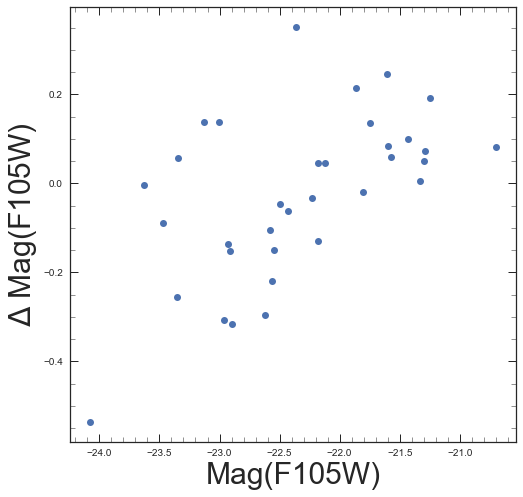

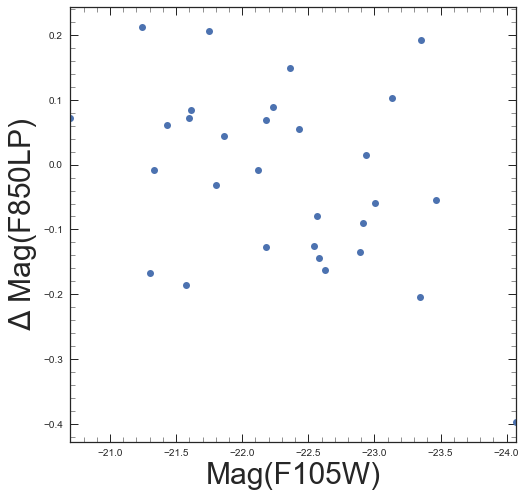

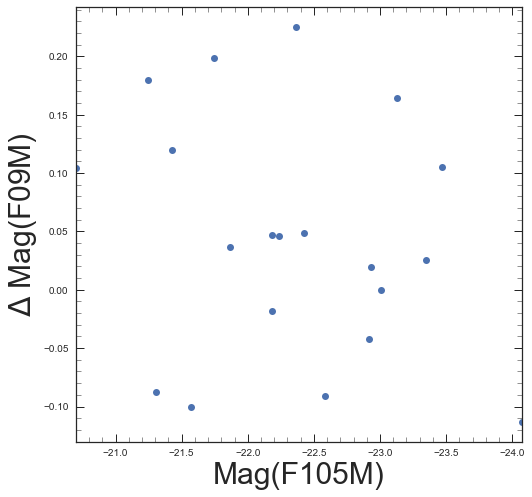

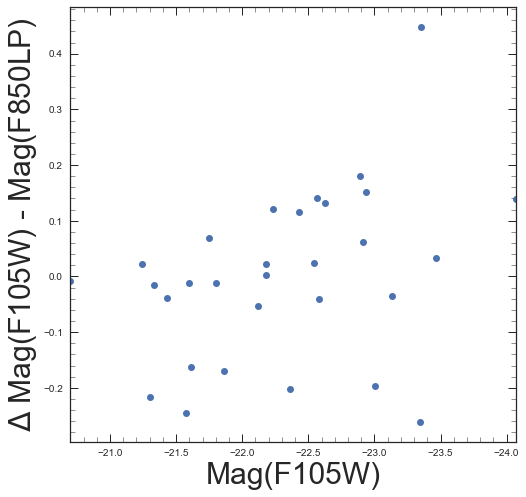

In [148]:
###PLOT 
%matplotlib inline

plt.figure(figsize=[8,8])
plt.plot(-25-Magnitude(f105DB['meas-f105']/Clam),Magnitude(f105DB['sim-f105']/f105DB['meas-f105']),'o')
plt.ylabel('$\Delta$ Mag(F105W)',fontsize = 30)
plt.xlabel('Mag(F105W)',fontsize = 30)
# plt.xlim(max(-25-Magnitude(smpDB['meas-f105']/Clam)),min(-25-Magnitude(smpDB['meas-f105']/Clam)))
plt.show()
# plt.savefig('../plots/df105.png')
plt.close()

plt.figure(figsize=[8,8])
plt.plot(-25-Magnitude(f850DB['meas-f105']/Clam),Magnitude(f850DB['sim-f850']/f850DB['meas-f850']),'o')
plt.ylabel('$\Delta$ Mag(F850LP)',fontsize = 30)
plt.xlabel('Mag(F105W)',fontsize = 30)
plt.xlim(max(-25-Magnitude(smpDB['meas-f105']/Clam)),min(-25-Magnitude(smpDB['meas-f105']/Clam)))
plt.show()
# plt.savefig('../plots/df850.png')
plt.close()

plt.figure(figsize=[8,8])
plt.plot(-25-Magnitude(f098DB['meas-f105']/Clam),Magnitude(f098DB['sim-f098']/f098DB['meas-f098']),'o')
plt.ylabel('$\Delta$ Mag(F09M)',fontsize = 30)
plt.xlabel('Mag(F105M)',fontsize = 30)
plt.xlim(max(-25-Magnitude(smpDB['meas-f105']/Clam)),min(-25-Magnitude(smpDB['meas-f105']/Clam)))
plt.show()
# plt.savefig('../plots/df098.png')
plt.close()

plt.figure(figsize=[8,8])
plt.plot(-25-Magnitude(f850DB['meas-f105']/Clam),Magnitude((f850DB['sim-f850']*f850DB['meas-f105'])/(f850DB['meas-f850']*f850DB['sim-f105'])),'o')
plt.ylabel('$\Delta$ Mag(F105W) - Mag(F850LP)',fontsize = 30)
plt.xlabel('Mag(F105W)',fontsize = 30)
plt.xlim(max(-25-Magnitude(smpDB['meas-f105']/Clam)),min(-25-Magnitude(smpDB['meas-f105']/Clam)))
plt.show()
# plt.savefig('../plots/df105_f850.png')
plt.close()

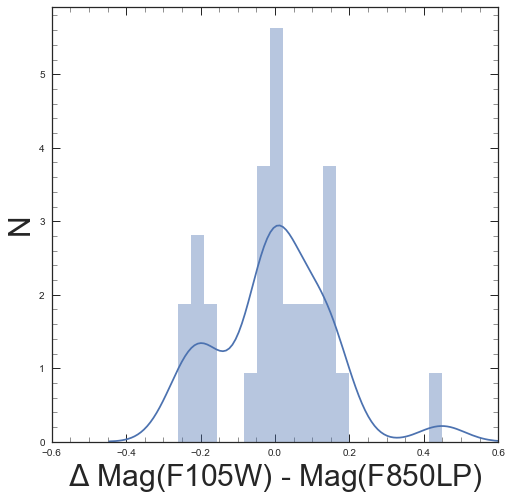

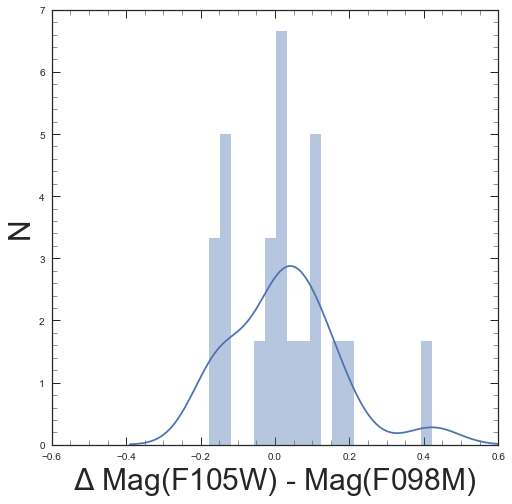

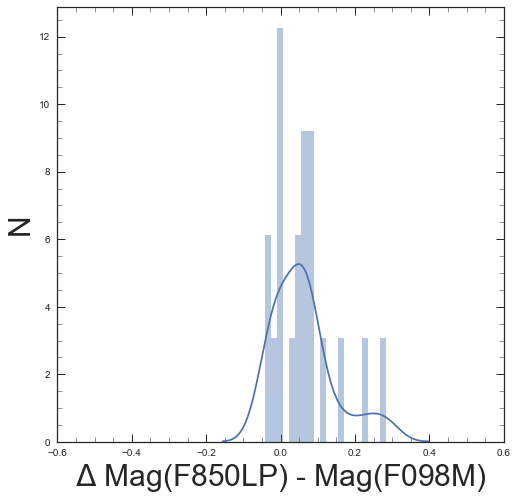

In [147]:
###PLOT 
%matplotlib inline

plt.figure(figsize=[8,8])
sea.distplot(Magnitude((f850DB['sim-f850']*f850DB['meas-f105'])/(f850DB['meas-f850']*f850DB['sim-f105'])),20)
plt.xlabel('$\Delta$ Mag(F105W) - Mag(F850LP)',fontsize = 30)
plt.ylabel('N',fontsize = 30)
plt.xlim(-.6,.6)
plt.show()
# plt.savefig('../plots/df105_850_dist.png')
plt.close()

plt.figure(figsize=[8,8])
sea.distplot(Magnitude((f098DB['sim-f098']*f098DB['meas-f105'])/(f098DB['meas-f098']*f098DB['sim-f105'])),20)
plt.xlabel('$\Delta$ Mag(F105W) - Mag(F098M)',fontsize = 30)
plt.ylabel('N',fontsize = 30)
plt.xlim(-.6,.6)
plt.show()
# plt.savefig('../plots/df105_f098_dist.png')
plt.close()

plt.figure(figsize=[8,8])
sea.distplot(Magnitude((f098DB['sim-f098']*f098DB['meas-f850'])/(f098DB['meas-f098']*f098DB['sim-f850'])),20)
plt.xlabel('$\Delta$ Mag(F850LP) - Mag(F098M)',fontsize = 30)
plt.ylabel('N',fontsize = 30)
plt.xlim(-.6,.6)
plt.show()
# plt.savefig('../plots/df850_f098_dist.png')
plt.close()

In [157]:
###PLOT 
%matplotlib inline


plt.figure(figsize=[8,8])
plt.plot(SNr,Magnitude((f098DB['sim-f098']*f098DB['meas-f850'])/(f098DB['meas-f098']*f098DB['sim-f850'])),'o')
# plt.axhline(medr,color = 'r')
# plt.axhline(medr-mlerrr,color = 'k')
# plt.axhline(medr+mherrr,color = 'k')
plt.ylabel('$\Delta$ (Mag(F098M) - Mag(F850LP))',fontsize = 30)
plt.xlabel('Integrated SN',fontsize = 30)
plt.tick_params(axis='both', which='major', labelsize=17)
plt.gcf().subplots_adjust(left=0.15)
# plt.show()
plt.savefig('../plots/d_f098_f850.pdf')
plt.close()

In [150]:
f098DB.columns

Index([u'f098-effwv', u'f105-effwv', u'f850-effwv', u'gal_ids', u'meas-f098',
       u'meas-f098_err', u'meas-f105', u'meas-f105_err', u'meas-f850',
       u'meas-f850_err', u'sim-f098', u'sim-f098_err', u'sim-f105',
       u'sim-f105_err', u'sim-f850', u'sim-f850_err'],
      dtype='object')